### Exploring the Influence of Socioeconomic and Demographic Factors on Mental Health Outcomes in Canada

In [ ]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import numpy as np
import textwrap
from statsmodels.graphics.mosaicplot import mosaic

# The chosen solution alternative applied, detailed and evaluated

### Import dataset, Data Cleaning and Data preprocessing

In [4]:
# Load the dataset
data = pd.read_csv('pumf.csv')

# Combine column renaming into a single dictionary
column_rename = {
    # Disorder columns
    # 'Has_Mood_Disorder (Such as depression, bipolar disorder, mania or dysthymia)'
    'CCC_280A': 'Has_Mood_Disorder',
    # 'Has_Anxiety_Disorder (Such as a phobia, obsessive-compulsive disorder or a panic disorder)'
    'CCC_290A': 'Has_Anxiety_Disorder',
    'CCC_311': 'Has_PTSD',
    'CCC_332': 'Has_ADHD',
    # Socioeconomic/demographic columns
    'GENDER': 'Gender',
    'DHHGAGE': 'Age_Group',
    'SDCFIMM': 'Is_Immigrant',
    'SDCGVVM': 'Visible_Minority_Group',
    'SDCDVFLA': 'Is_Visible_Minority',
    'EDU_05': 'Highest_Education',
    'INCDVHH': 'Household_Income',
    'SORLGBTS': 'LGBTQ2_Status'
}

# Rename the columns in the dataset
data.rename(columns=column_rename, inplace=True)

# Define columns for analysis
socio_demog_columns = [
    'Gender', 'Age_Group', 'Is_Immigrant',
    'Visible_Minority_Group', 'Is_Visible_Minority',
    'Highest_Education', 'Household_Income', 'LGBTQ2_Status'
]
disorder_columns = [
    'Has_Mood_Disorder', 'Has_Anxiety_Disorder','Has_PTSD', 'Has_ADHD'
]

# Retain relevant columns
columns_needed = socio_demog_columns + disorder_columns
data = data[columns_needed]

# Define mappings for socio economic variables
mappings = {
    'Gender': {1: 'Men', 2: 'Women', 9: 'Not Stated'},
    'Age_Group': {
        1: '15_19', 2: '20_24', 3: '25_29', 4: '30_34',
        5: '35_44', 6: '45_54', 7: '55_64', 8: '65_over'
    },
    'Is_Immigrant': {1: 'Yes', 2: 'No', 9: 'Not Stated'},
    'Visible_Minority_Group': {
        1: 'South Asian', 2: 'Chinese', 3: 'Black',
        4: 'Filipino', 5: 'Other Visible Minorities',
        6: 'Not a Visible Minority', 99: 'Not Stated'
    },
    'Is_Visible_Minority': {1: 'Yes', 2: 'No', 9: 'Not Stated'},
    'Highest_Education': {
        1: '1. Less than high school diploma',
        2: '2. High school diploma or equivalent',
        3: '3. Trades certificate or diploma',
        4: '4. College or non-university diploma',
        5: '5. University certificate below bachelor level',
        6: '6. Bachelor’s degree',
        7: '7. University certificate above bachelor level',
        99: 'Not Stated'
    },
    'Household_Income': {
        1: '01. No income or income loss',
        2: '02. Less than $5,000', 3: '03. $5,000 to $9,999',
        4: '04. $10,000 to $14,999', 5: '05. $15,000 to $19,999',
        6: '06. $20,000 to $29,999', 7: '07. $30,000 to $39,999',
        8: '08. $40,000 to $49,999', 9: '09. $50,000 to $59,999',
        10: '10. $60,000 to $69,999', 11: '11. $70,000 to $79,999',
        12: '12. $80,000 to $89,999', 13: '13. $90,000 to $99,999',
        14: '14. $100,000 to less than $150,000', 15: '15. $150,000 or more',
        99: 'Not Stated'
    },
    'LGBTQ2_Status': {1: 'LGBTQ2+ person', 2: 'Non-LGBTQ2+ person', 9: 'Not Stated'}
}
disorder_response_mapping = {1: 'Yes', 2: 'No', 6: 'Valid Skip', 7: 'Don’t Know', 8: 'Refusal', 9: 'Not Stated'}

# Apply mappings
data = data.apply(lambda col: col.map(mappings[col.name]) if col.name in mappings else col)
for column in disorder_columns:
    data[column] = data[column].map(disorder_response_mapping)

# Replace non-informative responses with NaN
non_informative = ['Don’t Know', 'Refusal', 'Not Stated', 'Valid Skip']
data.replace(non_informative, pd.NA, inplace=True)

data.isna().sum()

Gender                     16
Age_Group                   0
Is_Immigrant              262
Visible_Minority_Group    368
Is_Visible_Minority       368
Highest_Education         232
Household_Income           63
LGBTQ2_Status             298
Has_Mood_Disorder          52
Has_Anxiety_Disorder       72
Has_PTSD                   49
Has_ADHD                   76
dtype: int64

In [5]:
# Drop rows with NaN in key variables
data.dropna(inplace=True)

# Convert disorder columns and binary columns to binary values
binary_mapping = {'Yes': 1, 'No': 0}
for col in disorder_columns:
    data[col] = data[col].map(binary_mapping).astype('float')

binary_columns = {'Is_Visible_Minority': {'Yes': 1, 'No': 0}, 'Is_Immigrant': {'Yes': 1, 'No': 0}, 'LGBTQ2_Status': {'LGBTQ2+ person': 1, 'Non-LGBTQ2+ person': 0}}
data = data.assign(**{col: data[col].map(binary_columns[col]).astype('float') for col in binary_columns})

# Display the cleaned dataset
data.head()

,Gender,Age_Group,Is_Immigrant,Visible_Minority_Group,Is_Visible_Minority,Highest_Education,Household_Income,LGBTQ2_Status,Has_Mood_Disorder,Has_Anxiety_Disorder,Has_PTSD,Has_ADHD
0,Men,55_64,0.0,Not a Visible Minority,0.0,3. Trades certificate or diploma,"15. $150,000 or more",0.0,0.0,0.0,0.0,0.0
1,Women,20_24,0.0,Not a Visible Minority,0.0,6. Bachelor’s degree,"13. $90,000 to $99,999",0.0,0.0,0.0,0.0,0.0
2,Men,45_54,1.0,South Asian,1.0,6. Bachelor’s degree,"14. $100,000 to less than $150,000",0.0,0.0,0.0,0.0,0.0
3,Women,20_24,0.0,Other Visible Minorities,1.0,6. Bachelor’s degree,"14. $100,000 to less than $150,000",0.0,0.0,0.0,0.0,0.0
4,Men,20_24,1.0,South Asian,1.0,2. High school diploma or equivalent,"10. $60,000 to $69,999",0.0,0.0,0.0,0.0,0.0


### Check low frequencies (lower than 5)

In [11]:
def check_low_frequencies(data, var1, var2, threshold=5):
    """
    Check for low frequencies in the contingency table for two variables.

    Parameters:
    - data: pandas DataFrame containing the data.
    - var1: str, name of the first variable.
    - var2: str, name of the second variable.
    - threshold: int, the minimum acceptable frequency.

    Returns:
    - low_frequency_cells: List of cells with frequencies below the threshold.
    """
    # Create a contingency table
    contingency_table = pd.crosstab(data[var1], data[var2])

    # Find cells with low frequencies
    low_frequency_cells = contingency_table[contingency_table < threshold].stack().reset_index()
    low_frequency_cells.columns = [var1, var2, 'Frequency']

    return low_frequency_cells if not low_frequency_cells.empty else None

# Loop through disorder and socio economic variables to check for low frequencies
low_freq_report = []
for disorder in disorder_columns:
    for variable in socio_demog_columns:
        low_freq_cells = check_low_frequencies(data, variable, disorder)
        if low_freq_cells is not None:
            low_freq_report.append((variable, disorder, low_freq_cells))

# Display results
for variable, disorder, report in low_freq_report:
    print(f"Low frequencies found in '{variable}' vs '{disorder}':")
    print(report)
    print("-" * 70)


Low frequencies found in 'Household_Income' vs 'Has_Mood_Disorder':
               Household_Income  Has_Mood_Disorder  Frequency
0  01. No income or income loss                1.0        4.0
1          02. Less than $5,000                1.0        3.0
2          03. $5,000 to $9,999                1.0        4.0
----------------------------------------------------------------------
Low frequencies found in 'Household_Income' vs 'Has_Anxiety_Disorder':
               Household_Income  Has_Anxiety_Disorder  Frequency
0  01. No income or income loss                   1.0        4.0
1          02. Less than $5,000                   1.0        3.0
2          03. $5,000 to $9,999                   1.0        3.0
----------------------------------------------------------------------
Low frequencies found in 'Visible_Minority_Group' vs 'Has_PTSD':
  Visible_Minority_Group  Has_PTSD  Frequency
0               Filipino       1.0        3.0
------------------------------------------------------

### Combine some categories to fix low frequencies

In [3]:
# Load the dataset
data = pd.read_csv('pumf.csv')

# Combine column renaming into a single dictionary
column_rename = {
    # Disorder columns
    'CCC_280A': 'Has_Mood_Disorder',
    'CCC_290A': 'Has_Anxiety_Disorder',
    'CCC_311': 'Has_PTSD',
    'CCC_332': 'Has_ADHD',
    # Socioeconomic/demographic columns
    'GENDER': 'Gender',
    'DHHGAGE': 'Age_Group',
    'SDCFIMM': 'Is_Immigrant',
    'SDCGVVM': 'Visible_Minority_Group',
    'SDCDVFLA': 'Is_Visible_Minority',
    'EDU_05': 'Highest_Education',
    'INCDVHH': 'Household_Income',
    'SORLGBTS': 'LGBTQ2_Status'
}

# Rename the columns in the dataset
data.rename(columns=column_rename, inplace=True)

# Define columns for analysis
socio_demog_columns = [
    'Gender', 'Age_Group', 'Is_Immigrant',
    'Visible_Minority_Group', 'Is_Visible_Minority',
    'Highest_Education', 'Household_Income', 'LGBTQ2_Status'
]
disorder_columns = [
    'Has_Mood_Disorder', 'Has_Anxiety_Disorder','Has_PTSD', 'Has_ADHD'
]

# Retain relevant columns
columns_needed = socio_demog_columns + disorder_columns
data = data[columns_needed]

# Define mappings for socio economic variables
mappings = {
    'Gender': {1: 'Men', 2: 'Women', 9: 'Not Stated'},
    'Age_Group': {
        1: '15_19', 2: '20_24', 3: '25_29', 4: '30_34',
        5: '35_44', 6: '45_54', 7: '55_64', 8: '65_over'
    },
    'Is_Immigrant': {1: 'Yes', 2: 'No', 9: 'Not Stated'},
    'Visible_Minority_Group': {
        1: 'South Asian', 2: 'Chinese', 3: 'Black',
        # Merge categories 'Filipino' into 'Other Visible Minorities'
        4: 'Other Visible Minorities', 5: 'Other Visible Minorities',
        6: 'Not a Visible Minority', 99: 'Not Stated'
    },
    'Is_Visible_Minority': {1: 'Yes', 2: 'No', 9: 'Not Stated'},
    'Highest_Education': {
        1: '1. Less than high school diploma',
        2: '2. High school diploma or equivalent',
        3: '3. Trades certificate or diploma',
        4: '4. College or non-university diploma',
        5: '5. University certificate below bachelor level',
        6: '6. Bachelor’s degree',
        7: '7. University certificate above bachelor level',
        99: 'Not Stated'
    },
    'Household_Income': {
        # Merge categories 1-5 into '01. Less than $19,999'
        1: '01. Less than $19,999',  
        2: '01. Less than $19,999',
        3: '01. Less than $19,999',
        4: '01. Less than $19,999',
        5: '01. Less than $19,999',
        # Merge categories 6-7 into '02. $20,000 to $39,999'
        6: '02. $20,000 to $39,999',
        7: '02. $20,000 to $39,999',
        # Merge categories 8-9 into '03. $40,000 to $59,999'
        8: '03. $40,000 to $59,999',
        9: '03. $40,000 to $59,999',
        # Categories 10-11 become '04. $60,000 to $79,999'
        10: '04. $60,000 to $79,999',
        11: '04. $60,000 to $79,999',
        # Categories 12-13 become '05. $80,000 to $99,999'
        12: '05. $80,000 to $99,999',
        13: '05. $80,000 to $99,999',
        # Category 14 remains as '06. $100,000 to less than $150,000'
        14: '06. $100,000 to less than $150,000',
        # Category 15 remains as '07. $150,000 or more'
        15: '07. $150,000 or more',
        # Category 99 remains as 'Not Stated'
        99: 'Not Stated'
    },
    'LGBTQ2_Status': {1: 'LGBTQ2+ person', 2: 'Non-LGBTQ2+ person', 9: 'Not Stated'}
}
disorder_response_mapping = {1: 'Yes', 2: 'No', 6: 'Valid Skip', 7: 'Don’t Know', 8: 'Refusal', 9: 'Not Stated'}

# Apply mappings
data = data.apply(lambda col: col.map(mappings[col.name]) if col.name in mappings else col)
for column in disorder_columns:
    data[column] = data[column].map(disorder_response_mapping)

# Replace non-informative responses with NaN
non_informative = ['Don’t Know', 'Refusal', 'Not Stated', 'Valid Skip']
data.replace(non_informative, pd.NA, inplace=True)

### Double check low frequencies

In [17]:
def check_low_frequencies(data, var1, var2, threshold=5):
    """
    Check for low frequencies in the contingency table for two variables.

    Parameters:
    - data: pandas DataFrame containing the data.
    - var1: str, name of the first variable.
    - var2: str, name of the second variable.
    - threshold: int, the minimum acceptable frequency.

    Returns:
    - low_frequency_cells: List of cells with frequencies below the threshold.
    """
    # Create a contingency table
    contingency_table = pd.crosstab(data[var1], data[var2])

    # Find cells with low frequencies
    low_frequency_cells = contingency_table[contingency_table < threshold].stack().reset_index()
    low_frequency_cells.columns = [var1, var2, 'Frequency']

    return low_frequency_cells if not low_frequency_cells.empty else None

# Loop through disorder and socio economic variables to check for low frequencies
low_freq_report = []
for disorder in disorder_columns:
    for variable in socio_demog_columns:
        low_freq_cells = check_low_frequencies(data, variable, disorder)
        if low_freq_cells is not None:
            low_freq_report.append((variable, disorder, low_freq_cells))

# Display results
for variable, disorder, report in low_freq_report:
    print(f"Low frequencies found in '{variable}' vs '{disorder}':")
    print(report)
    print("-" * 70)


# Actions and processes to support implementation of alternative detailed

# Chi Squared


Chi-squared test: Gender vs Has_Mood_Disorder
Chi-squared statistic: 74.76
Degrees of freedom: 1
P-value: 0.0000
Statistically significant association (p = 0.0000).


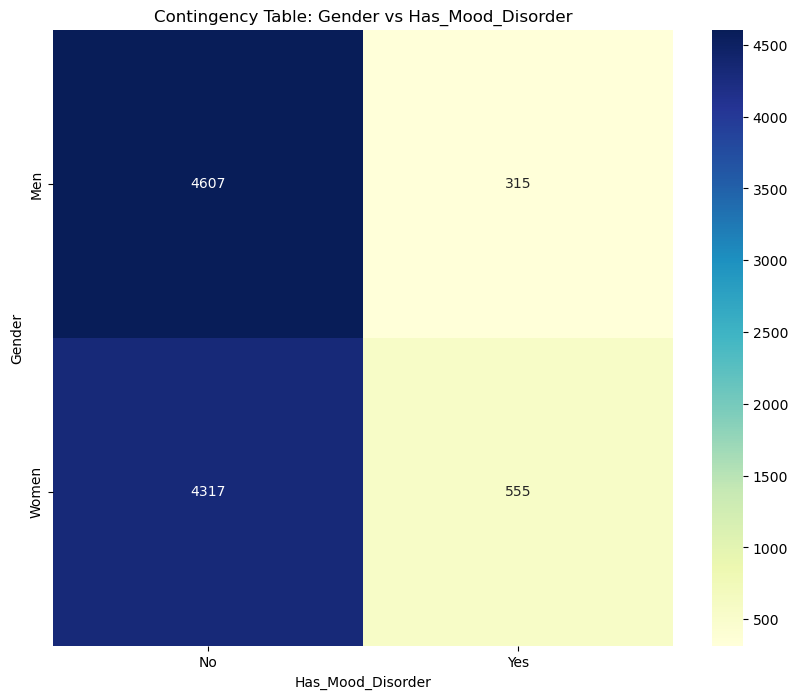

----------------------------------------------------------------------

Chi-squared test: Age_Group vs Has_Mood_Disorder
Chi-squared statistic: 89.32
Degrees of freedom: 7
P-value: 0.0000
Statistically significant association (p = 0.0000).


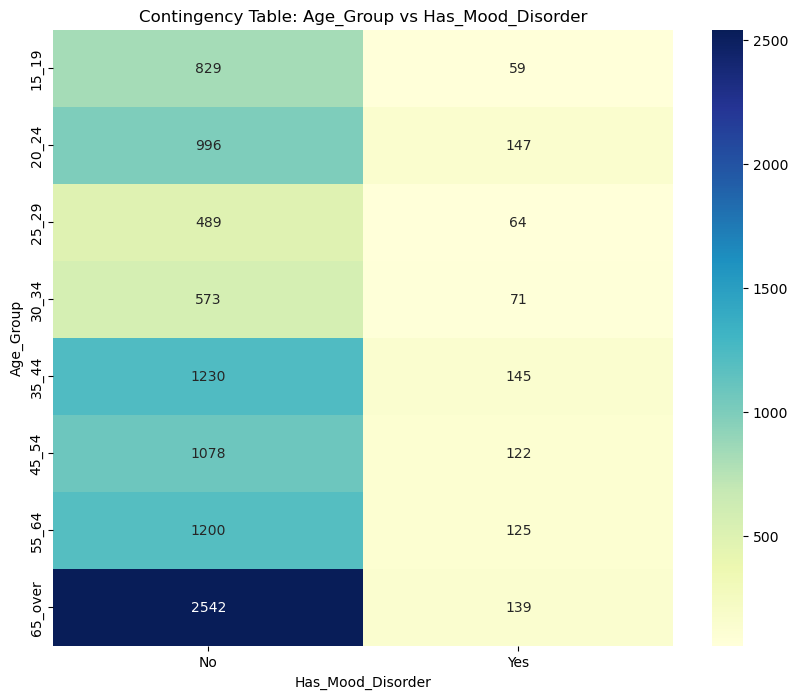

----------------------------------------------------------------------

Chi-squared test: Is_Immigrant vs Has_Mood_Disorder
Chi-squared statistic: 163.87
Degrees of freedom: 1
P-value: 0.0000
Statistically significant association (p = 0.0000).


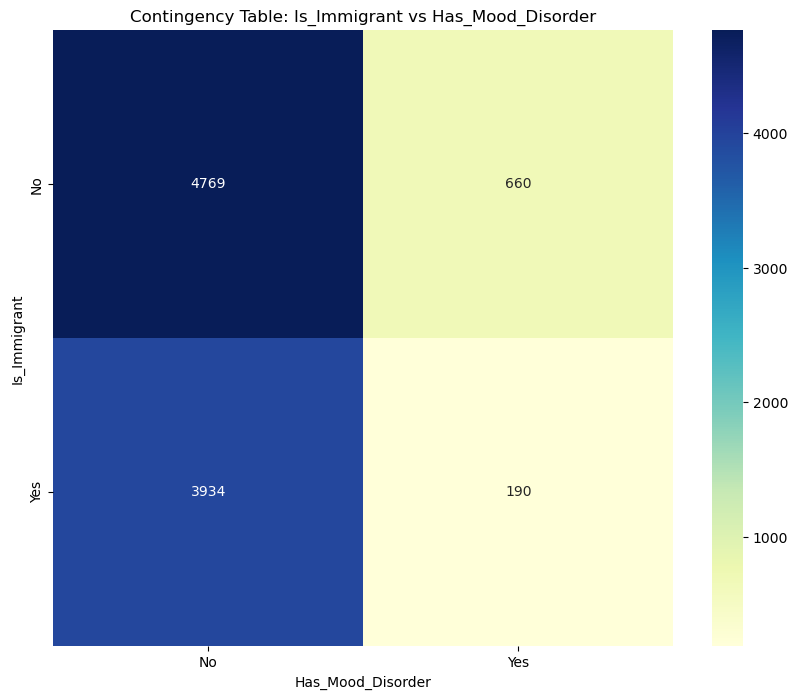

----------------------------------------------------------------------

Chi-squared test: Visible_Minority_Group vs Has_Mood_Disorder
Chi-squared statistic: 117.53
Degrees of freedom: 4
P-value: 0.0000
Statistically significant association (p = 0.0000).


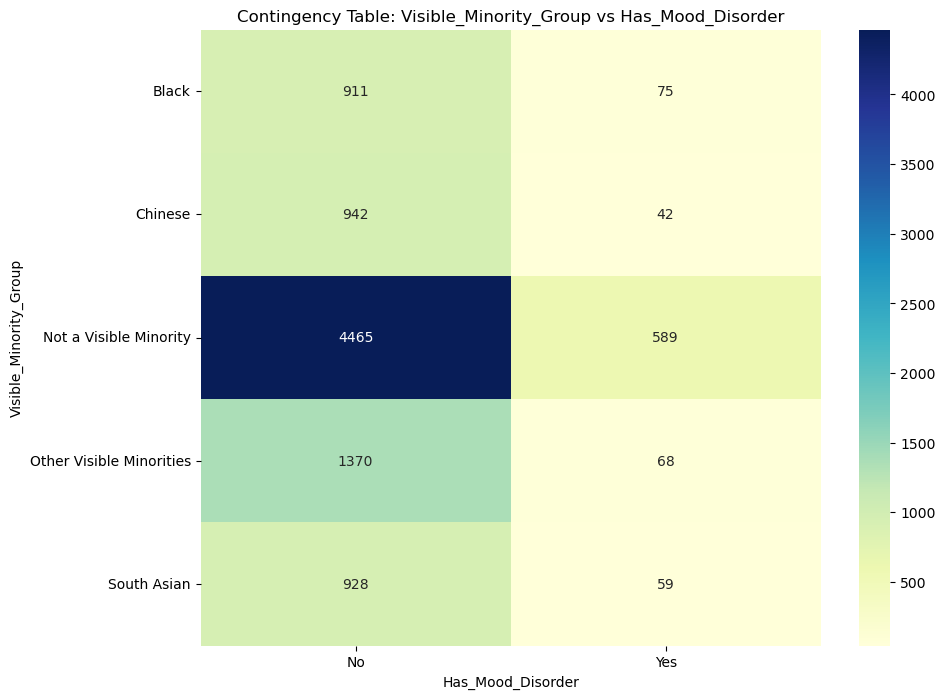

----------------------------------------------------------------------

Chi-squared test: Is_Visible_Minority vs Has_Mood_Disorder
Chi-squared statistic: 108.14
Degrees of freedom: 1
P-value: 0.0000
Statistically significant association (p = 0.0000).


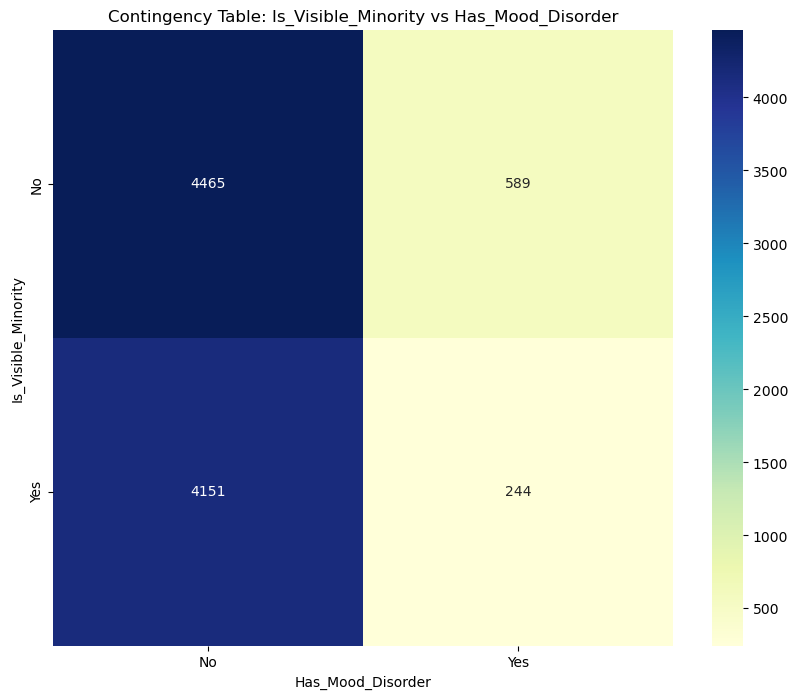

----------------------------------------------------------------------

Chi-squared test: Highest_Education vs Has_Mood_Disorder
Chi-squared statistic: 33.98
Degrees of freedom: 6
P-value: 0.0000
Statistically significant association (p = 0.0000).


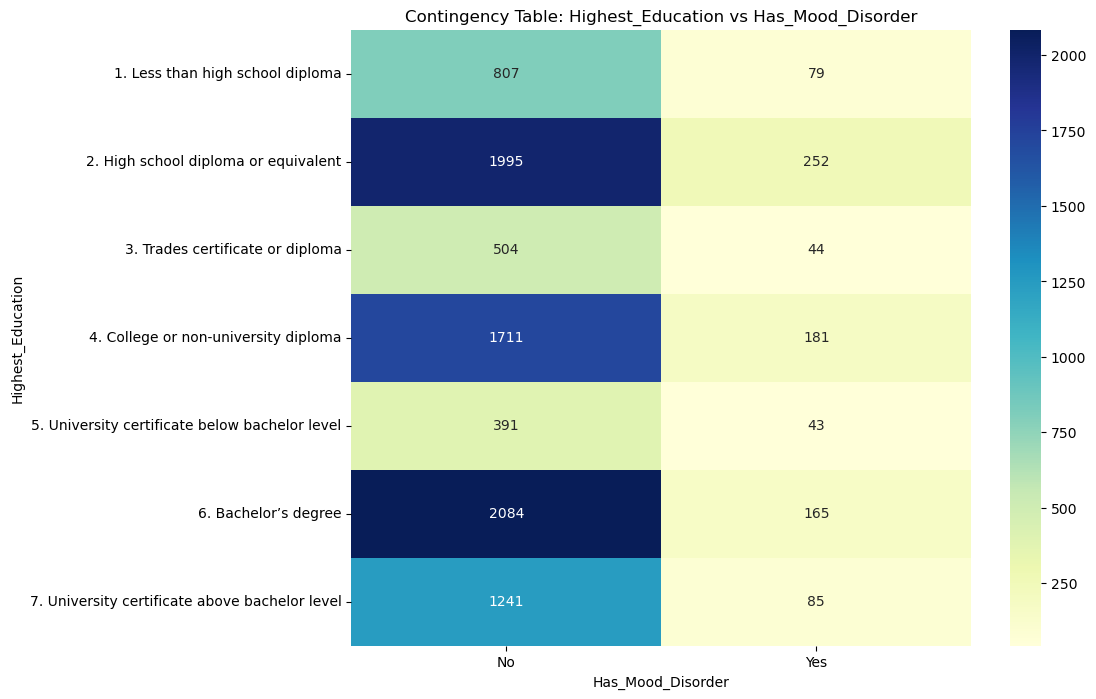

----------------------------------------------------------------------

Chi-squared test: Household_Income vs Has_Mood_Disorder
Chi-squared statistic: 12.05
Degrees of freedom: 6
P-value: 0.0608
No statistically significant association (p = 0.0608).
----------------------------------------------------------------------

Chi-squared test: LGBTQ2_Status vs Has_Mood_Disorder
Chi-squared statistic: 228.03
Degrees of freedom: 1
P-value: 0.0000
Statistically significant association (p = 0.0000).


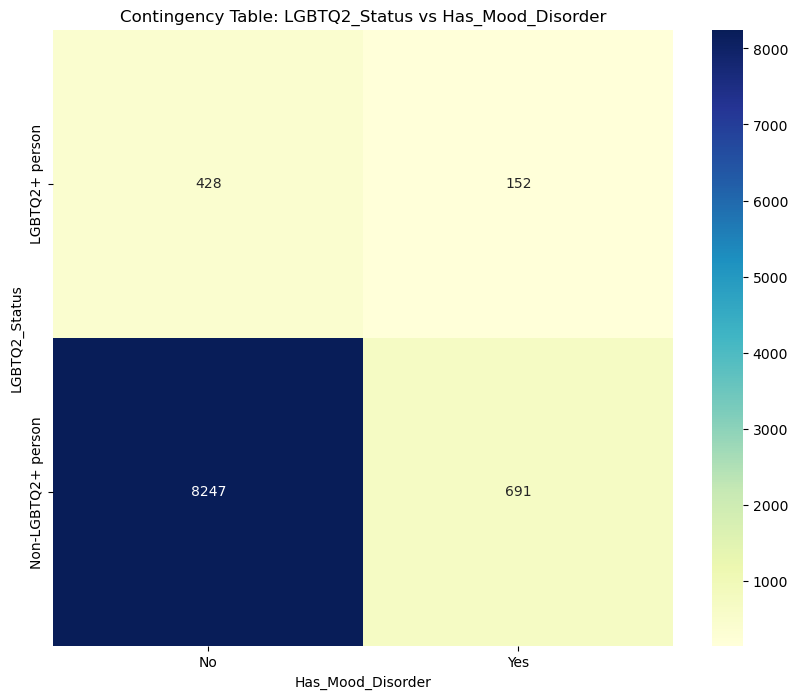

----------------------------------------------------------------------

Chi-squared test: Gender vs Has_Anxiety_Disorder
Chi-squared statistic: 57.14
Degrees of freedom: 1
P-value: 0.0000
Statistically significant association (p = 0.0000).


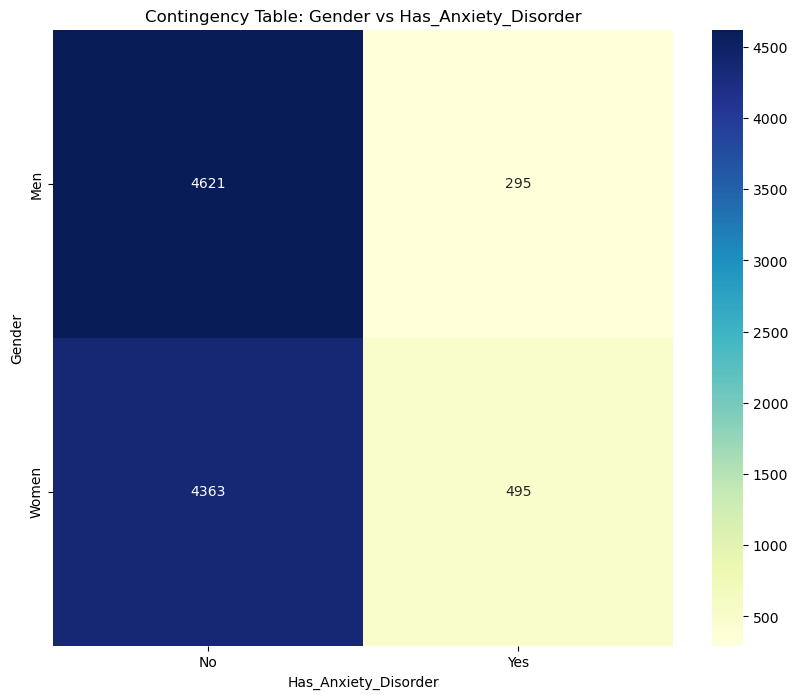

----------------------------------------------------------------------

Chi-squared test: Age_Group vs Has_Anxiety_Disorder
Chi-squared statistic: 107.98
Degrees of freedom: 7
P-value: 0.0000
Statistically significant association (p = 0.0000).


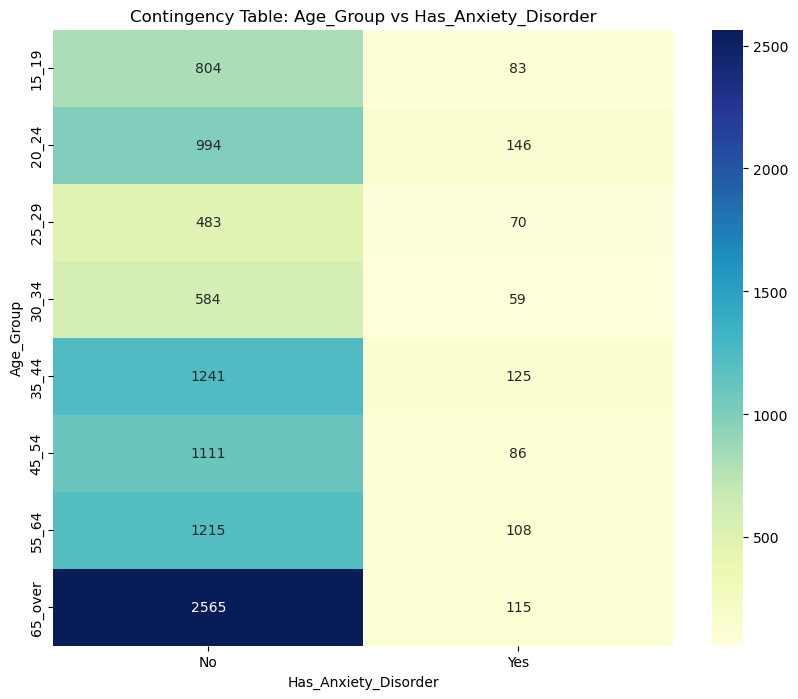

----------------------------------------------------------------------

Chi-squared test: Is_Immigrant vs Has_Anxiety_Disorder
Chi-squared statistic: 175.04
Degrees of freedom: 1
P-value: 0.0000
Statistically significant association (p = 0.0000).


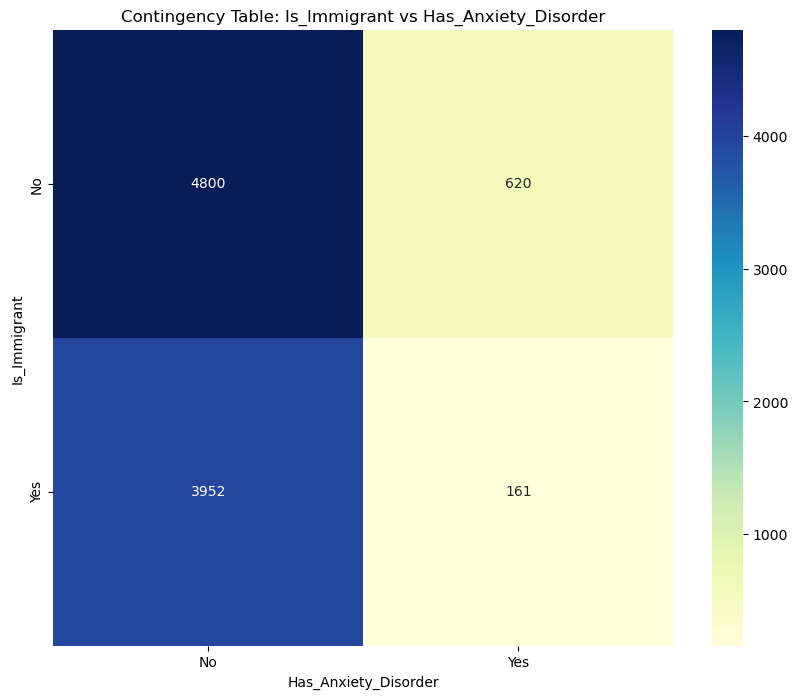

----------------------------------------------------------------------

Chi-squared test: Visible_Minority_Group vs Has_Anxiety_Disorder
Chi-squared statistic: 130.52
Degrees of freedom: 4
P-value: 0.0000
Statistically significant association (p = 0.0000).


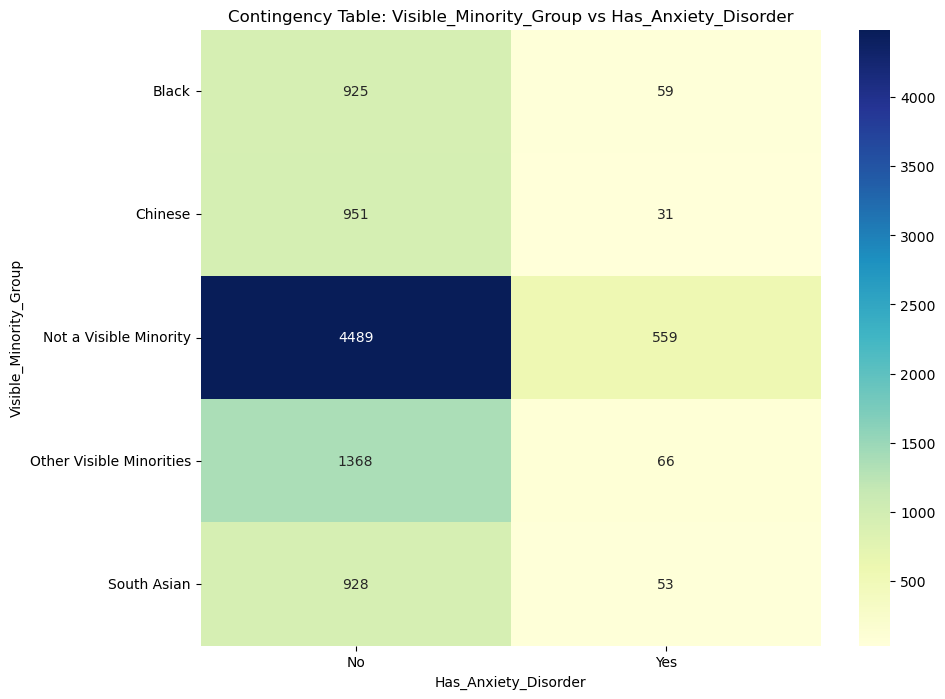

----------------------------------------------------------------------

Chi-squared test: Is_Visible_Minority vs Has_Anxiety_Disorder
Chi-squared statistic: 123.71
Degrees of freedom: 1
P-value: 0.0000
Statistically significant association (p = 0.0000).


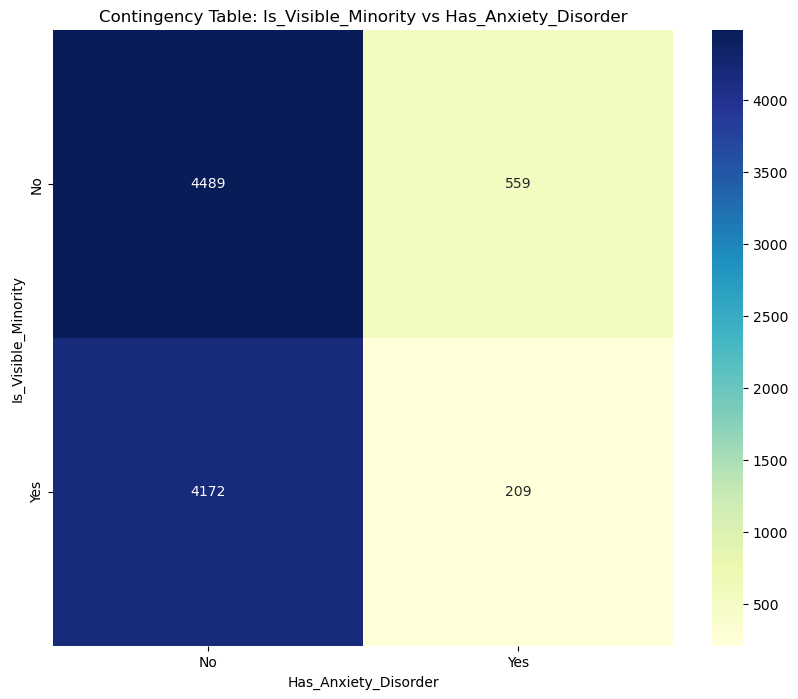

----------------------------------------------------------------------

Chi-squared test: Highest_Education vs Has_Anxiety_Disorder
Chi-squared statistic: 38.39
Degrees of freedom: 6
P-value: 0.0000
Statistically significant association (p = 0.0000).


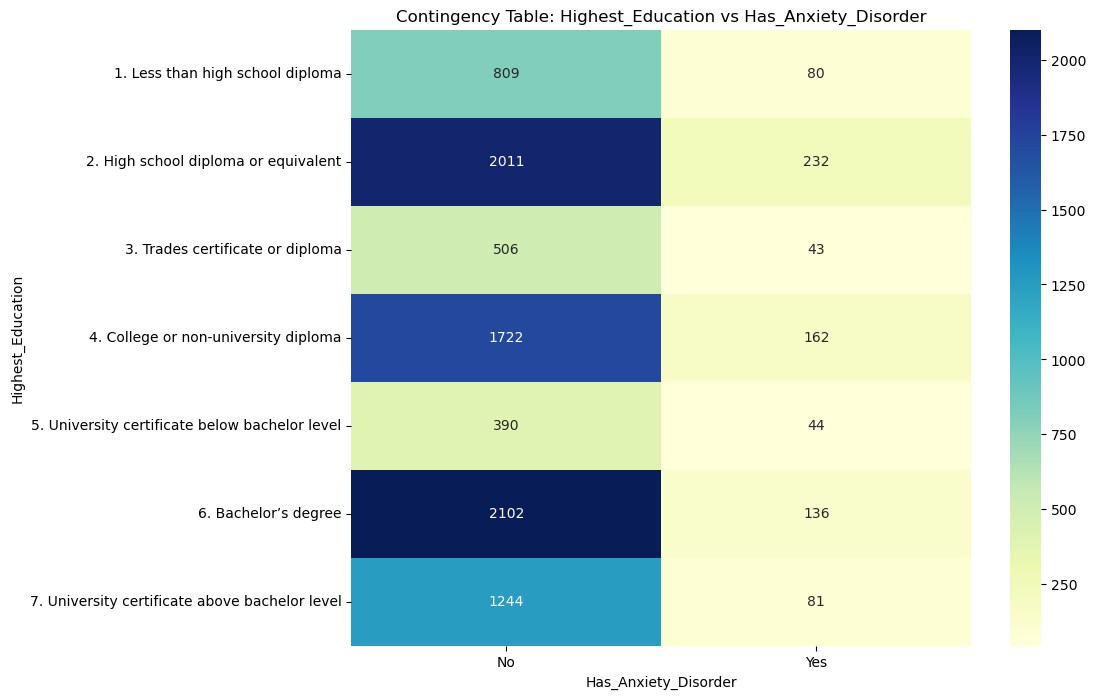

----------------------------------------------------------------------

Chi-squared test: Household_Income vs Has_Anxiety_Disorder
Chi-squared statistic: 9.93
Degrees of freedom: 6
P-value: 0.1278
No statistically significant association (p = 0.1278).
----------------------------------------------------------------------

Chi-squared test: LGBTQ2_Status vs Has_Anxiety_Disorder
Chi-squared statistic: 212.58
Degrees of freedom: 1
P-value: 0.0000
Statistically significant association (p = 0.0000).


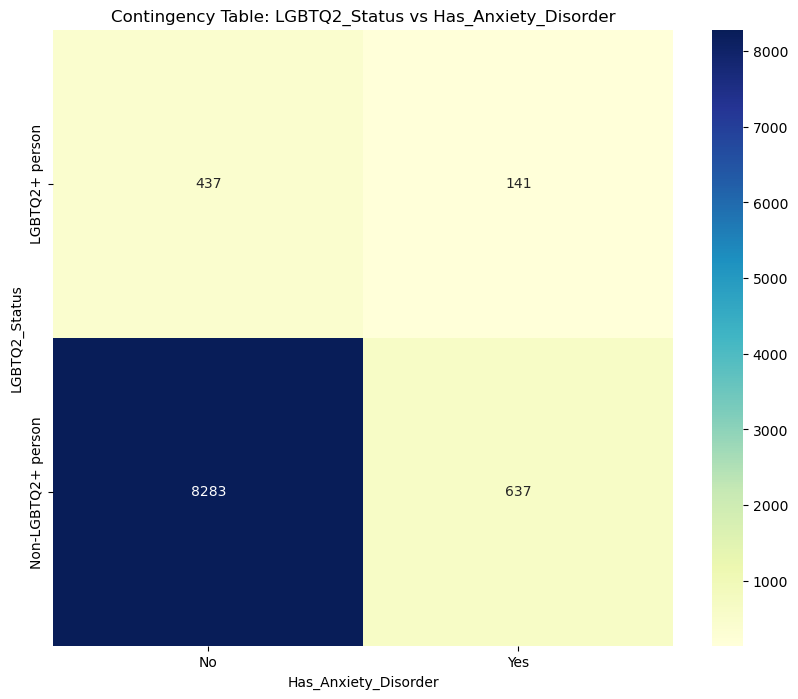

----------------------------------------------------------------------

Chi-squared test: Gender vs Has_PTSD
Chi-squared statistic: 27.00
Degrees of freedom: 1
P-value: 0.0000
Statistically significant association (p = 0.0000).


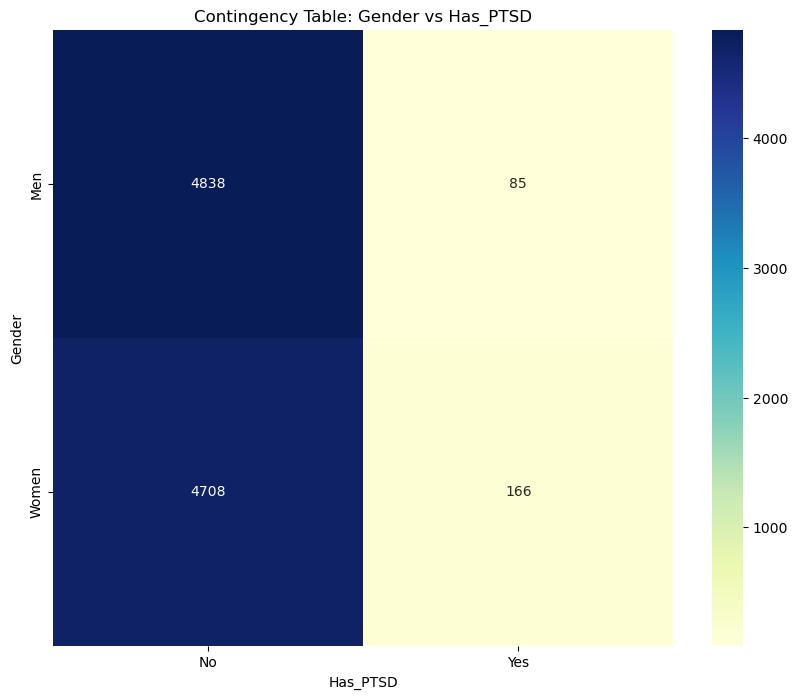

----------------------------------------------------------------------

Chi-squared test: Age_Group vs Has_PTSD
Chi-squared statistic: 24.62
Degrees of freedom: 7
P-value: 0.0009
Statistically significant association (p = 0.0009).


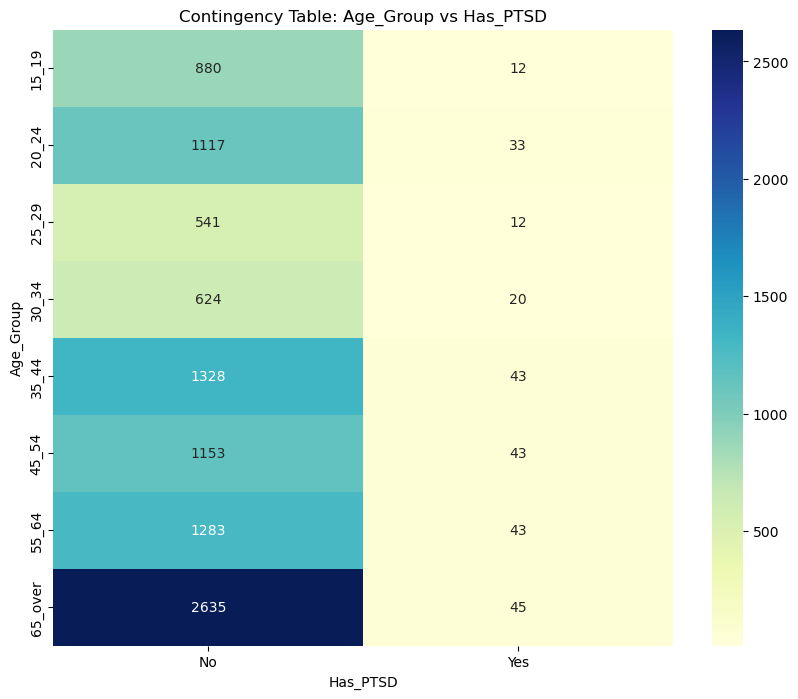

----------------------------------------------------------------------

Chi-squared test: Is_Immigrant vs Has_PTSD
Chi-squared statistic: 18.99
Degrees of freedom: 1
P-value: 0.0000
Statistically significant association (p = 0.0000).


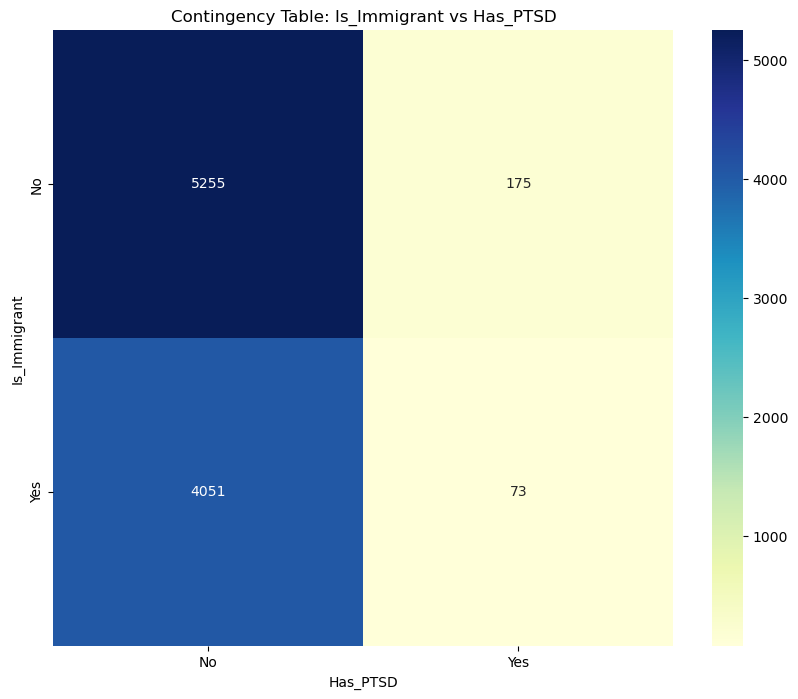

----------------------------------------------------------------------

Chi-squared test: Visible_Minority_Group vs Has_PTSD
Chi-squared statistic: 34.10
Degrees of freedom: 4
P-value: 0.0000
Statistically significant association (p = 0.0000).


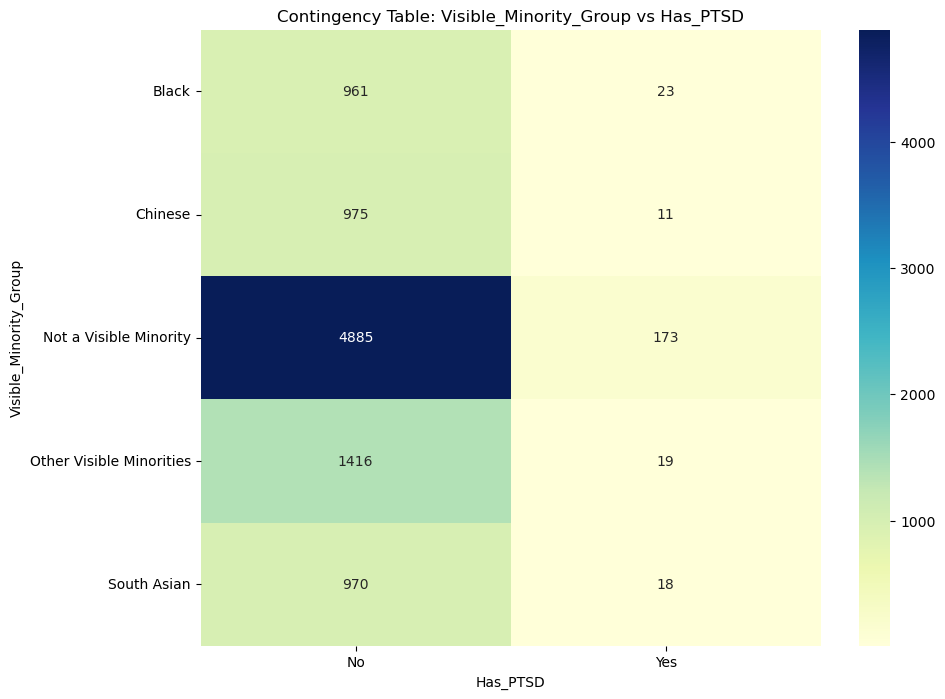

----------------------------------------------------------------------

Chi-squared test: Is_Visible_Minority vs Has_PTSD
Chi-squared statistic: 29.71
Degrees of freedom: 1
P-value: 0.0000
Statistically significant association (p = 0.0000).


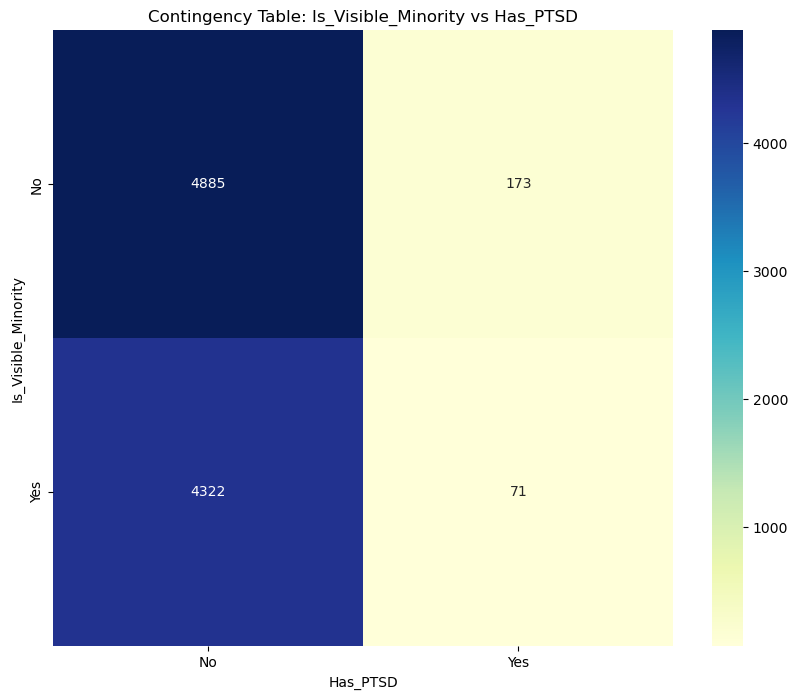

----------------------------------------------------------------------

Chi-squared test: Highest_Education vs Has_PTSD
Chi-squared statistic: 12.05
Degrees of freedom: 6
P-value: 0.0608
No statistically significant association (p = 0.0608).
----------------------------------------------------------------------

Chi-squared test: Household_Income vs Has_PTSD
Chi-squared statistic: 18.38
Degrees of freedom: 6
P-value: 0.0054
Statistically significant association (p = 0.0054).


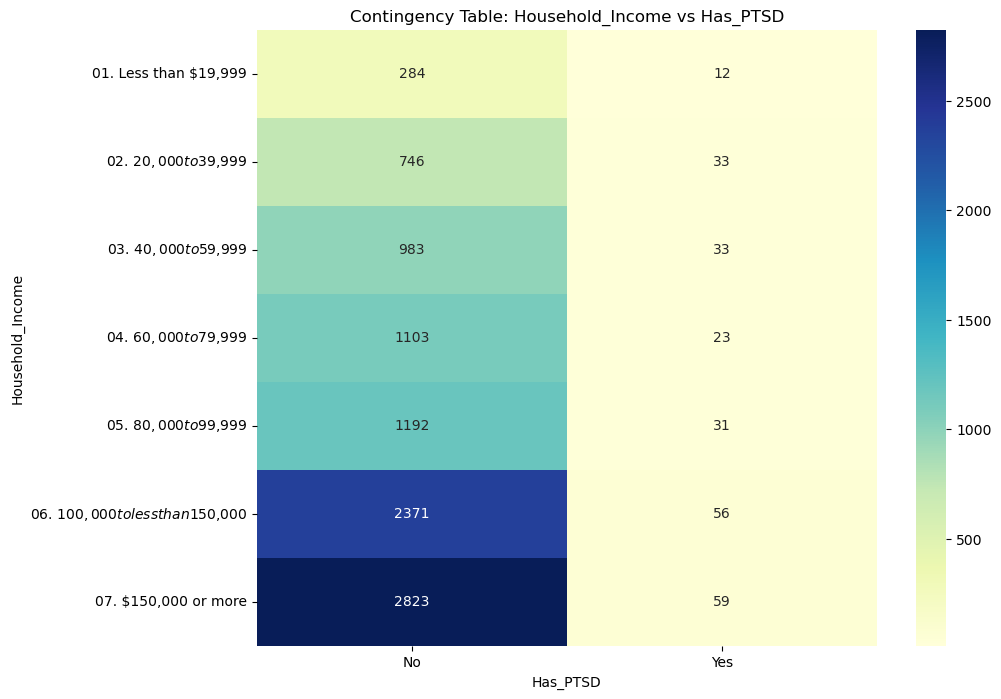

----------------------------------------------------------------------

Chi-squared test: LGBTQ2_Status vs Has_PTSD
Chi-squared statistic: 42.88
Degrees of freedom: 1
P-value: 0.0000
Statistically significant association (p = 0.0000).


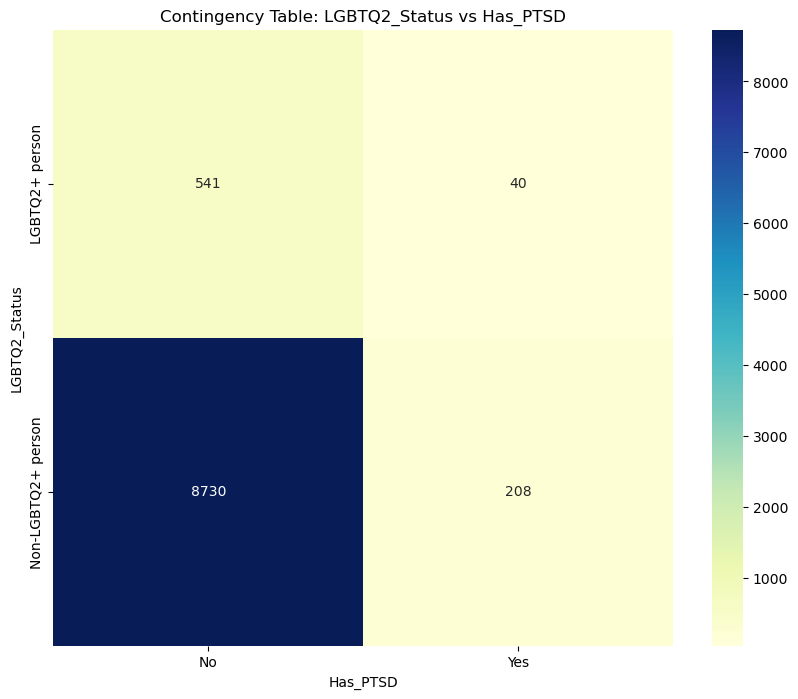

----------------------------------------------------------------------

Chi-squared test: Gender vs Has_ADHD
Chi-squared statistic: 9.29
Degrees of freedom: 1
P-value: 0.0023
Statistically significant association (p = 0.0023).


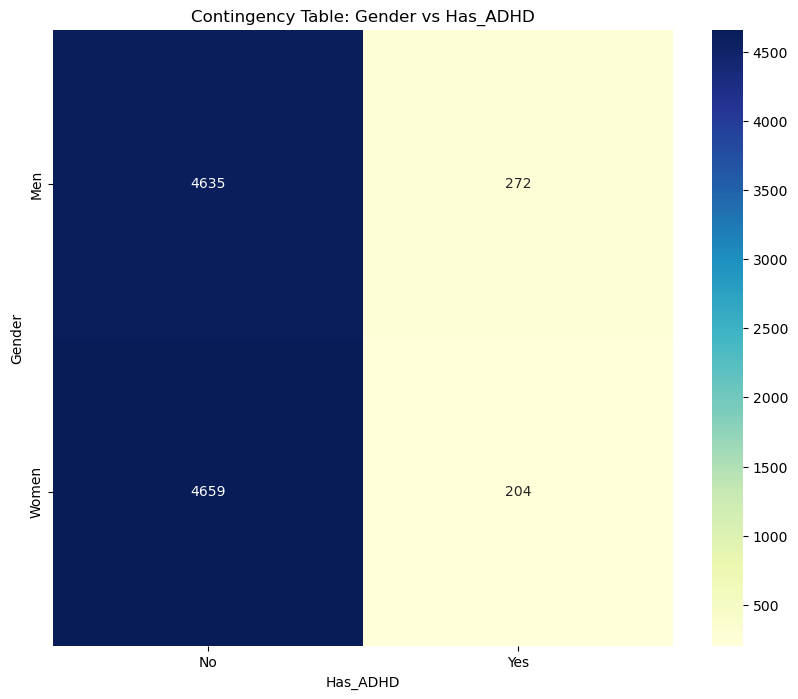

----------------------------------------------------------------------

Chi-squared test: Age_Group vs Has_ADHD
Chi-squared statistic: 192.82
Degrees of freedom: 7
P-value: 0.0000
Statistically significant association (p = 0.0000).


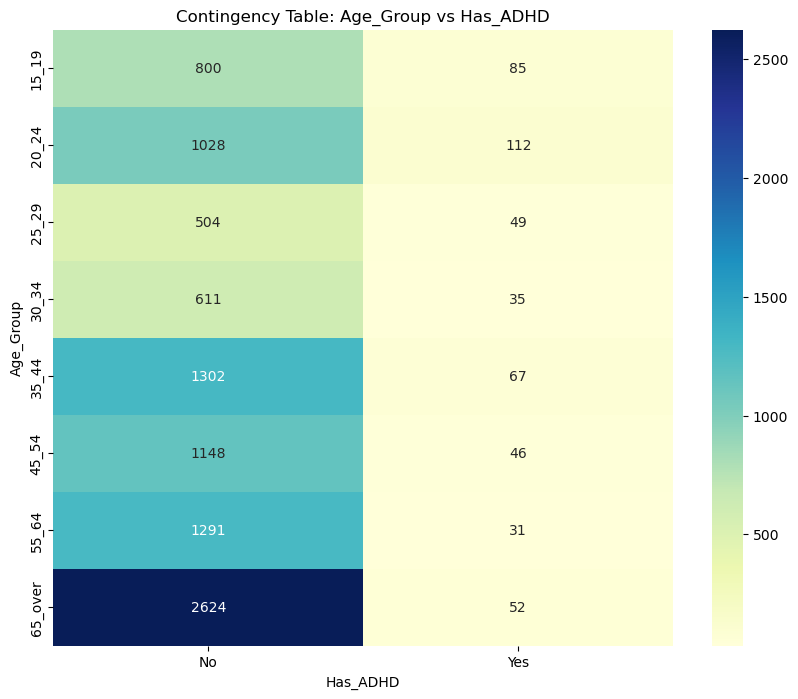

----------------------------------------------------------------------

Chi-squared test: Is_Immigrant vs Has_ADHD
Chi-squared statistic: 149.94
Degrees of freedom: 1
P-value: 0.0000
Statistically significant association (p = 0.0000).


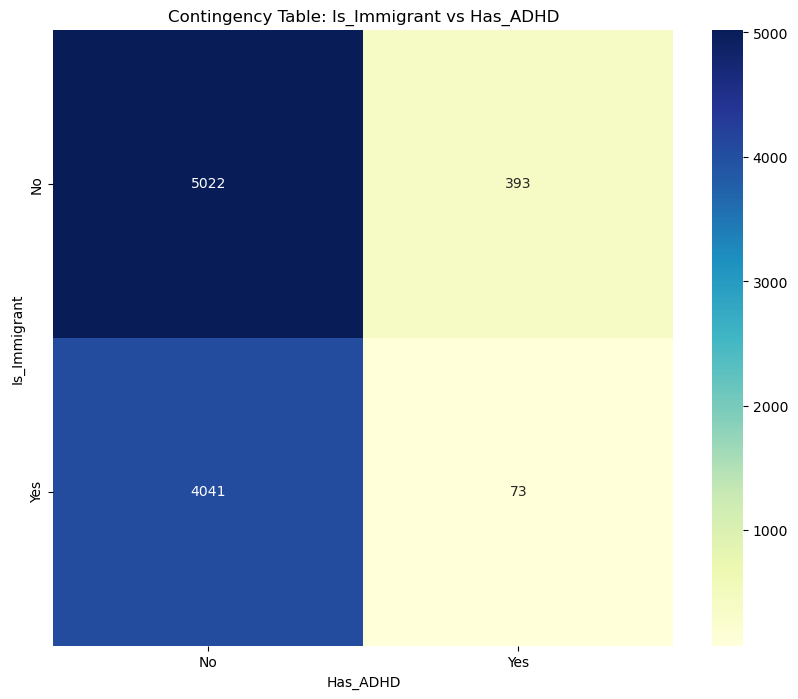

----------------------------------------------------------------------

Chi-squared test: Visible_Minority_Group vs Has_ADHD
Chi-squared statistic: 110.24
Degrees of freedom: 4
P-value: 0.0000
Statistically significant association (p = 0.0000).


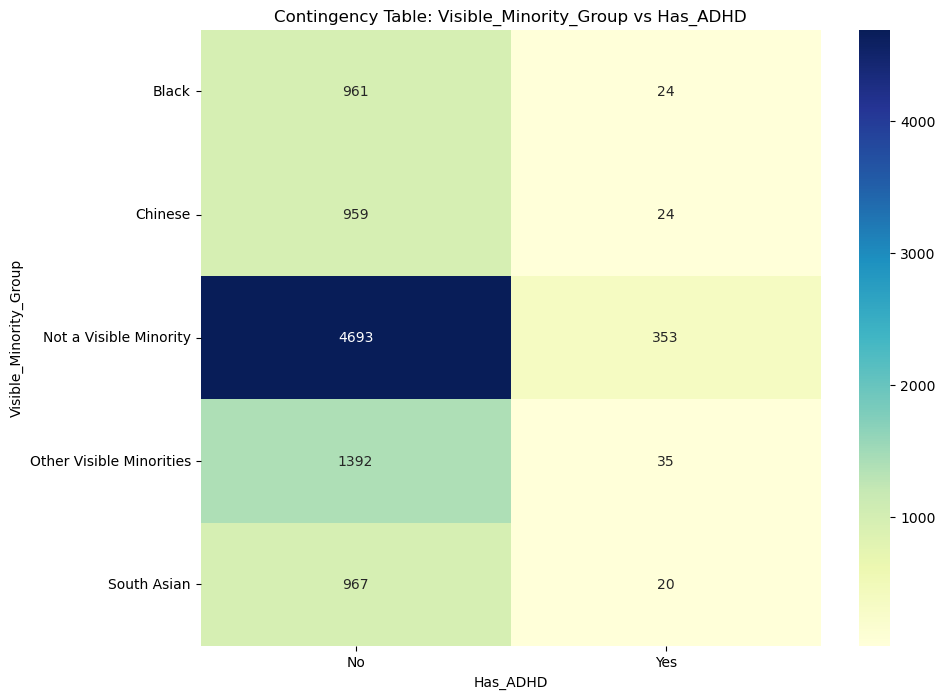

----------------------------------------------------------------------

Chi-squared test: Is_Visible_Minority vs Has_ADHD
Chi-squared statistic: 108.94
Degrees of freedom: 1
P-value: 0.0000
Statistically significant association (p = 0.0000).


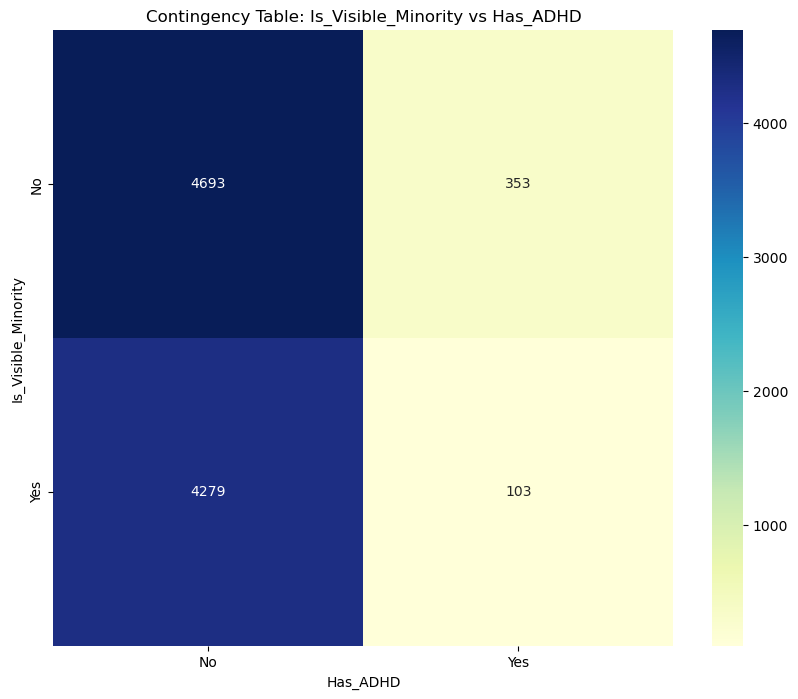

----------------------------------------------------------------------

Chi-squared test: Highest_Education vs Has_ADHD
Chi-squared statistic: 88.72
Degrees of freedom: 6
P-value: 0.0000
Statistically significant association (p = 0.0000).


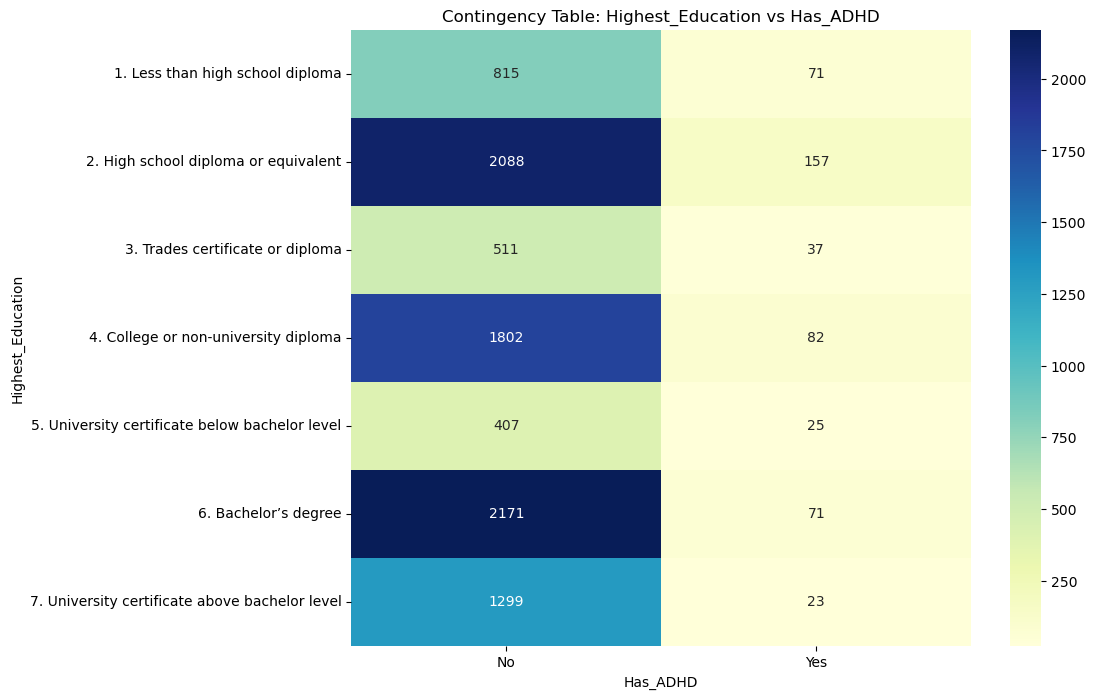

----------------------------------------------------------------------

Chi-squared test: Household_Income vs Has_ADHD
Chi-squared statistic: 6.94
Degrees of freedom: 6
P-value: 0.3267
No statistically significant association (p = 0.3267).
----------------------------------------------------------------------

Chi-squared test: LGBTQ2_Status vs Has_ADHD
Chi-squared statistic: 108.60
Degrees of freedom: 1
P-value: 0.0000
Statistically significant association (p = 0.0000).


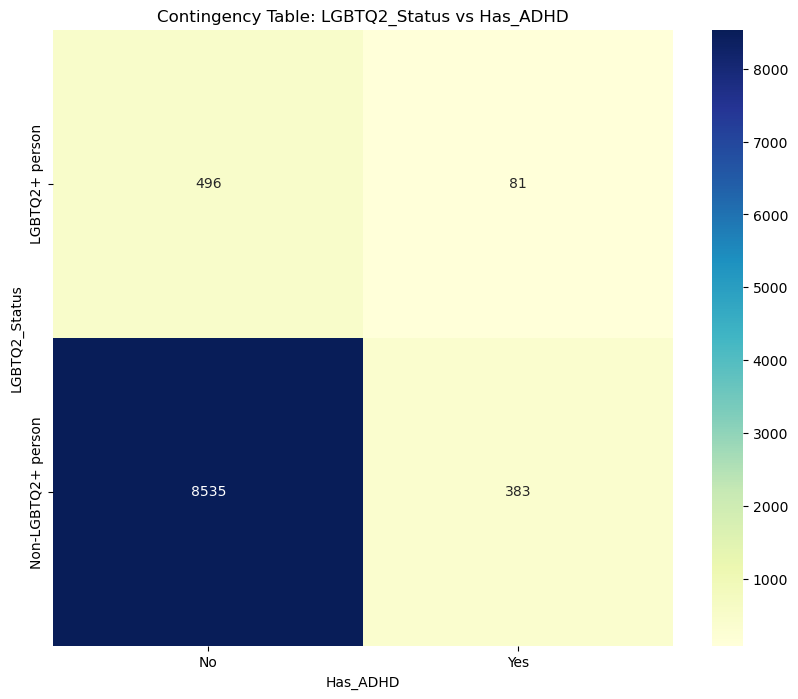

----------------------------------------------------------------------


In [21]:
# Define lists of relevant columns
disorder_columns = [
    'Has_Mood_Disorder', 'Has_Anxiety_Disorder', 'Has_PTSD', 'Has_ADHD']

socio_demog_columns = [
    'Gender', 'Age_Group', 'Is_Immigrant',
    'Visible_Minority_Group', 'Is_Visible_Minority',
    'Highest_Education', 'Household_Income', 'LGBTQ2_Status'
]

# Ensure socioeconomic data types for relevant columns
data[disorder_columns + socio_demog_columns] = data[disorder_columns + socio_demog_columns].astype('category')

def perform_chi_squared_test(data, var1, var2, significance_level=0.05, plot=True):
    """
    Perform a chi-squared test between two socio economic variables and optionally visualize the results.

    Parameters:
    - data: pandas DataFrame containing the dataset.
    - var1: str, the first variable.
    - var2: str, the second variable.
    - significance_level: float, the threshold for statistical significance.
    - plot: bool, if True, generates a heatmap of the contingency table for significant results.

    Returns:
    - None
    """
    # Filter out rows with missing data
    test_data = data[[var1, var2]].dropna()

    if test_data.empty:
        print(f"No valid data for chi-squared test between '{var1}' and '{var2}'.")
        return

    # Create contingency table
    contingency_table = pd.crosstab(test_data[var1], test_data[var2])

    if contingency_table.shape[0] < 2 or contingency_table.shape[1] < 2:
        print(f"Insufficient categories for chi-squared test between '{var1}' and '{var2}'.")
        return

    # Perform the chi-squared test
    chi2, p, dof, _ = chi2_contingency(contingency_table)

    # Display results
    print(f"\nChi-squared test: {var1} vs {var2}")
    print(f"Chi-squared statistic: {chi2:.2f}")
    print(f"Degrees of freedom: {dof}")
    print(f"P-value: {p:.4f}")

    # Determine statistical significance
    if p < significance_level:
        print(f"Statistically significant association (p = {p:.4f}).")
        if plot:
            plt.figure(figsize=(10, 8))
            sns.heatmap(contingency_table, annot=True, fmt='d', cmap='YlGnBu')
            plt.title(f'Contingency Table: {var1} vs {var2}')
            plt.ylabel(var1)
            plt.xlabel(var2)
            plt.show()
    else:
        print(f"No statistically significant association (p = {p:.4f}).")
    print("-" * 70)

# Run chi-squared tests for all disorder-socioeconomic variable pairs
for disorder in disorder_columns:
    for variable in socio_demog_columns:
        perform_chi_squared_test(data, variable, disorder)


# More visualizations used

'Gender', 'Age_Group', 'Is_Immigrant',
'Visible_Minority_Group', 'Is_Visible_Minority',
'Highest_Education', 'Household_Income', 'LGBTQ2_Status'


### Heatmap of P-Values Between Disorders and Socioeconomic Variables

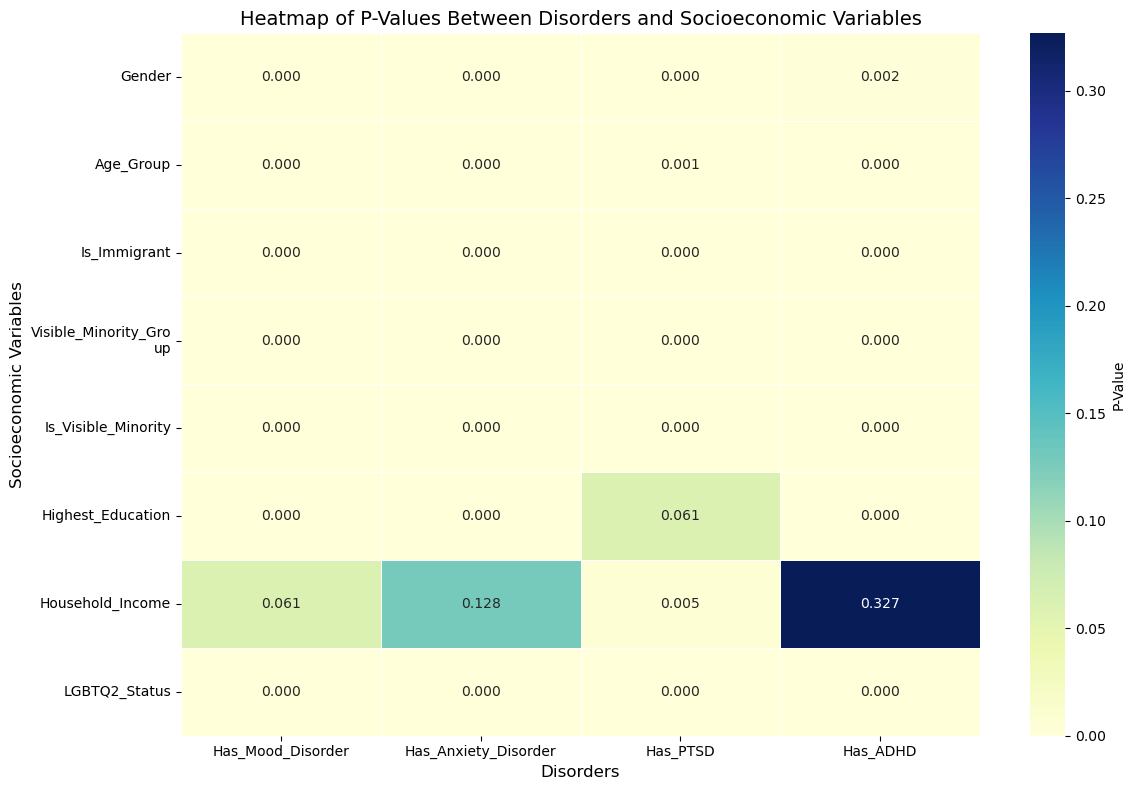

In [26]:
# Define the socioeconomic and disorder variables
socioeco_vars = [
    'Gender', 'Age_Group', 'Is_Immigrant',
    'Visible_Minority_Group', 'Is_Visible_Minority',
    'Highest_Education', 'Household_Income', 'LGBTQ2_Status'
]
disorder_vars = [
    'Has_Mood_Disorder',
    'Has_Anxiety_Disorder',
    'Has_PTSD', 'Has_ADHD'
]

# Prepare a DataFrame to store p-values from chi-squared tests
heatmap_data = pd.DataFrame(index=socioeco_vars, columns=disorder_vars)

# Perform chi-squared tests and store p-values
for socioeco_var in socioeco_vars:
    for disorder_var in disorder_vars:
        # Create contingency table
        contingency_table = pd.crosstab(data[socioeco_var], data[disorder_var])
        
        # Perform chi-squared test only if the contingency table is valid
        if contingency_table.shape[0] > 1 and contingency_table.shape[1] > 1:
            chi2, p, dof, _ = chi2_contingency(contingency_table)
            heatmap_data.loc[socioeco_var, disorder_var] = p
        else:
            heatmap_data.loc[socioeco_var, disorder_var] = np.nan  # Assign NaN for invalid tests

# Convert p-values to numeric for visualization
heatmap_data = heatmap_data.astype(float)

# Wrap disorder labels for better visualization
heatmap_data.columns = ['\n'.join(textwrap.wrap(label, width=20)) for label in heatmap_data.columns]
heatmap_data.index = ['\n'.join(textwrap.wrap(label, width=20)) for label in heatmap_data.index]

# Mask the upper triangle of the heatmap
# mask = np.triu(np.ones_like(heatmap_data, dtype=bool))

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data,
    # mask=mask,
    annot=True,
    fmt=".3f",
    cmap="YlGnBu",
    cbar_kws={'label': 'P-Value'},
    linewidths=0.5
)

# Add title and axis labels
plt.title("Heatmap of P-Values Between Disorders and Socioeconomic Variables", fontsize=14)
plt.xlabel("Disorders", fontsize=12)
plt.ylabel("Socioeconomic Variables", fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()




# Comparison of Mental Health Disorders Between Men and Women

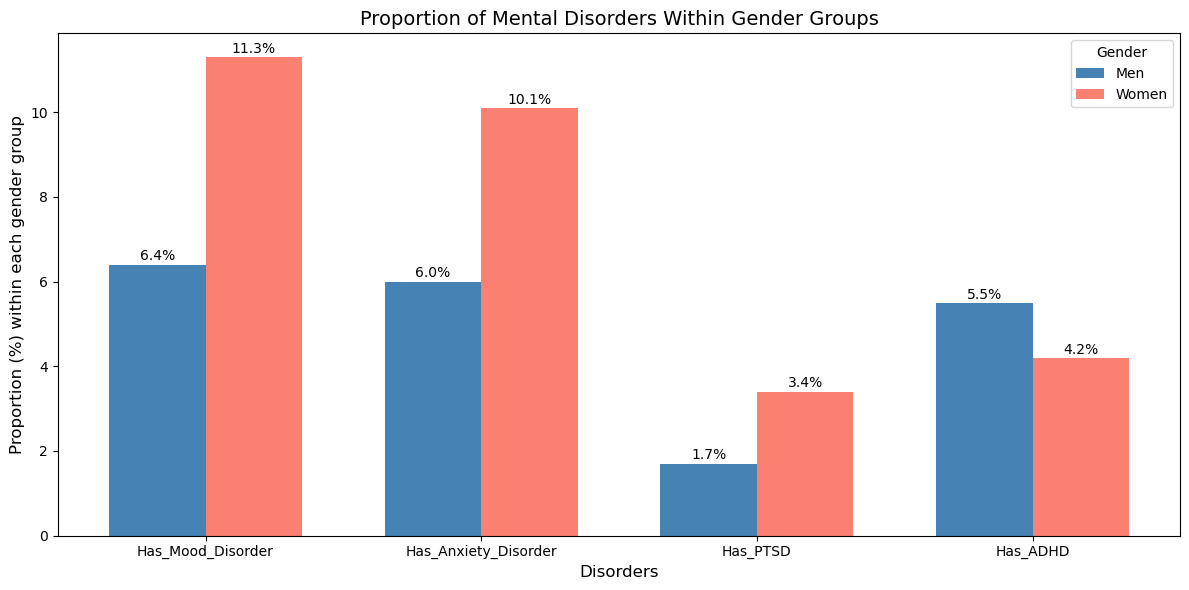

In [29]:
# Define the disorder columns
disorder_columns = [
    'Has_Mood_Disorder',
    'Has_Anxiety_Disorder',
    'Has_PTSD',
    'Has_ADHD'
]

# Define the Gender column
gender_column = 'Gender'

# Prepare data for proportions
genders = ['Men', 'Women']  # Gender categories
gender_proportions = {gender: [] for gender in genders}  # Dictionary to store proportions for each gender

# Initialize the disorder labels list
disorder_labels = []  # List to store disorder names

# Loop through each disorder to calculate proportions within each gender group
for disorder in disorder_columns:
    for gender in genders:
        # Filter the data for the specific gender
        group_data = data[data[gender_column] == gender]
        
        # Calculate the total count of individuals in this gender group
        total_in_group = len(group_data)
        
        # Calculate the proportion of individuals with the disorder in this group
        if total_in_group > 0:  # Avoid division by zero
            count_with_disorder = len(group_data[group_data[disorder] == "Yes"])
            proportion = (count_with_disorder / total_in_group) * 100
        else:
            proportion = 0
        
        # Append the proportion to the respective gender list
        gender_proportions[gender].append(round(proportion, 1))
    
    # Add the disorder label
    disorder_labels.append(disorder)

# Function to wrap disorder labels
def wrap_labels(labels, width=20):
    return ['\n'.join(textwrap.wrap(label, width)) for label in labels]

# Wrap disorder labels
wrapped_disorder_labels = wrap_labels(disorder_columns, width=30)

# Create grouped bar chart
x = np.arange(len(disorder_columns))  # x-axis positions for disorders
width = 0.35  # Width of each bar

plt.figure(figsize=(12, 6))

# Plot bars for Men and Women
bars_men = plt.bar(x - width/2, gender_proportions['Men'], width, label='Men', color='steelblue')
bars_women = plt.bar(x + width/2, gender_proportions['Women'], width, label='Women', color='salmon')

# Add titles and labels
plt.title('Proportion of Mental Disorders Within Gender Groups', fontsize=14)
plt.xlabel('Disorders', fontsize=12)
plt.ylabel('Proportion (%) within each gender group', fontsize=12)
plt.xticks(x, wrapped_disorder_labels, rotation=0)  # Apply wrapped labels to x-axis

# Add percentage labels on top of the bars
for bars, gender in zip([bars_men, bars_women], ['Men', 'Women']):
    for bar in bars:
        height = bar.get_height()
        if height > 0:  # Avoid labeling bars with zero height
            plt.text(bar.get_x() + bar.get_width() / 2, height + 0.1, f'{height:.1f}%', ha='center', fontsize=10)

# Add legend
plt.legend(title='Gender')

# Adjust layout and show plot
plt.tight_layout()
plt.show()


# Comparison of Mental Health Disorders Between LGBTQ2 group and Non LGBTQ2 group

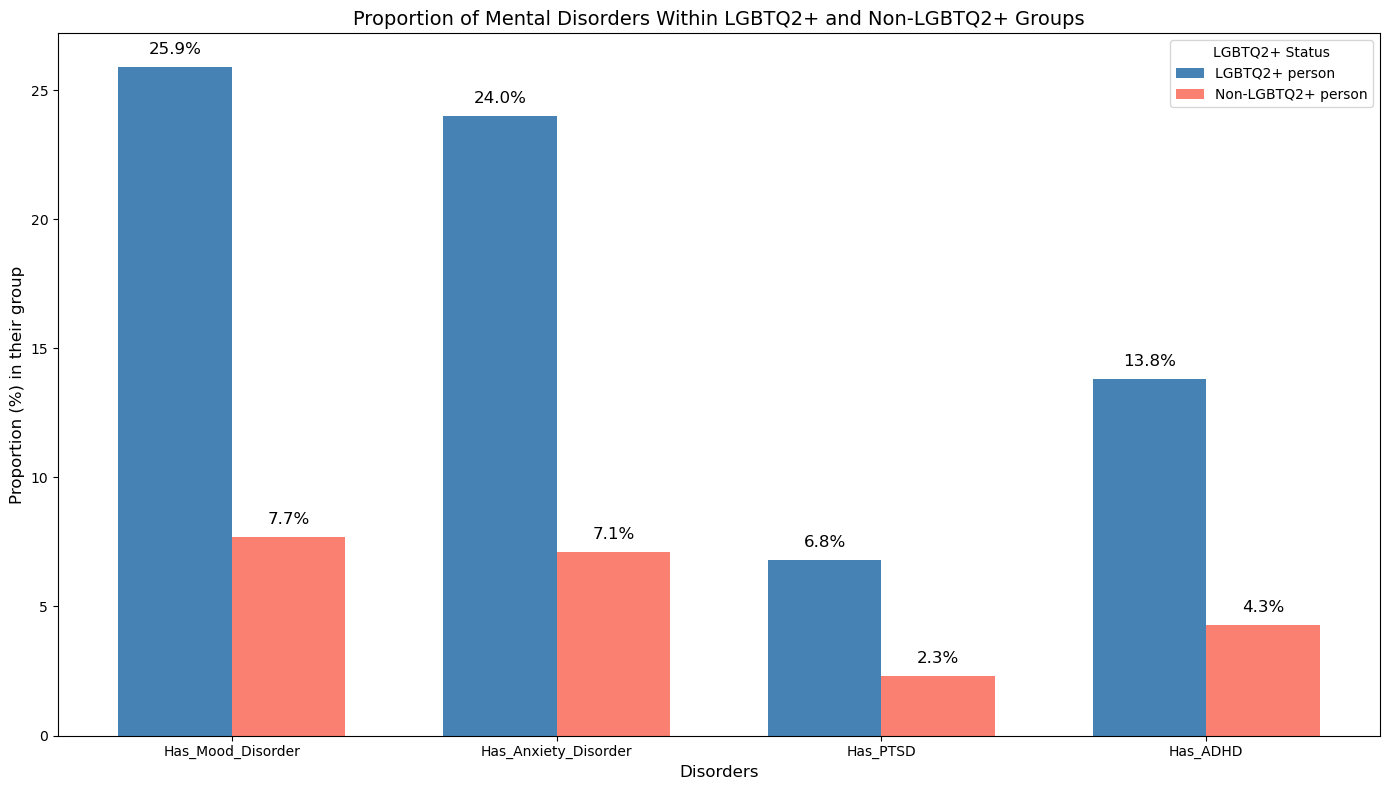

In [32]:
# Define the disorder columns
disorder_columns = [
    'Has_Mood_Disorder',
    'Has_Anxiety_Disorder',
    'Has_PTSD',
    'Has_ADHD'
]

# Define the LGBTQ2_Status column
lgbtq2_column = 'LGBTQ2_Status'

# Prepare data for proportions
lgbtq2_categories = ['LGBTQ2+ person', 'Non-LGBTQ2+ person']  # LGBTQ2+ categories
proportions = {category: [] for category in lgbtq2_categories}  # Dictionary to store proportions for each group

# Initialize the disorder labels list
disorder_labels = []  # List to store disorder names

# Loop through each disorder to calculate proportions within each group
for disorder in disorder_columns:
    for category in lgbtq2_categories:
        # Filter the data for the specific LGBTQ2_Status category
        group_data = data[data[lgbtq2_column] == category]
        
        # Calculate the proportion of individuals in this group who said "Yes" to the disorder
        total_in_group = len(group_data)
        if total_in_group > 0:  # Avoid division by zero
            count_with_disorder = len(group_data[group_data[disorder] == "Yes"])
            proportion = (count_with_disorder / total_in_group) * 100
        else:
            proportion = 0
        
        # Append the proportion to the respective category list
        proportions[category].append(round(proportion, 1))

# Function to wrap disorder labels
def wrap_labels(labels, width=20):
    return ['\n'.join(textwrap.wrap(label, width)) for label in labels]

# Wrap disorder labels
wrapped_disorder_labels = wrap_labels(disorder_columns, width=30)

# Create grouped bar chart
x = np.arange(len(disorder_columns))  # x-axis positions for disorders
width = 0.35  # Width of each bar

plt.figure(figsize=(14, 8))

# Plot bars for LGBTQ2+ and Non-LGBTQ2+ groups
bars_lgbtq2 = plt.bar(x - width/2, proportions['LGBTQ2+ person'], width, label='LGBTQ2+ person', color='steelblue')
bars_non_lgbtq2 = plt.bar(x + width/2, proportions['Non-LGBTQ2+ person'], width, label='Non-LGBTQ2+ person', color='salmon')

# Add titles and labels
plt.title('Proportion of Mental Disorders Within LGBTQ2+ and Non-LGBTQ2+ Groups', fontsize=14)
plt.xlabel('Disorders', fontsize=12)
plt.ylabel('Proportion (%) in their group', fontsize=12)
plt.xticks(x, wrapped_disorder_labels, rotation=0)  # Apply wrapped labels to x-axis

# Add percentage labels on top of the bars
for bars, category in zip([bars_lgbtq2, bars_non_lgbtq2], lgbtq2_categories):
    for bar in bars:
        height = bar.get_height()
        if height > 0:  # Avoid labeling bars with zero height
            plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f'{height:.1f}%', ha='center', fontsize=12)

# Add legend
plt.legend(title='LGBTQ2+ Status')

# Adjust layout and show plot
plt.tight_layout()
plt.show()


# Age-Wise Distribution of Mental Health Disorders

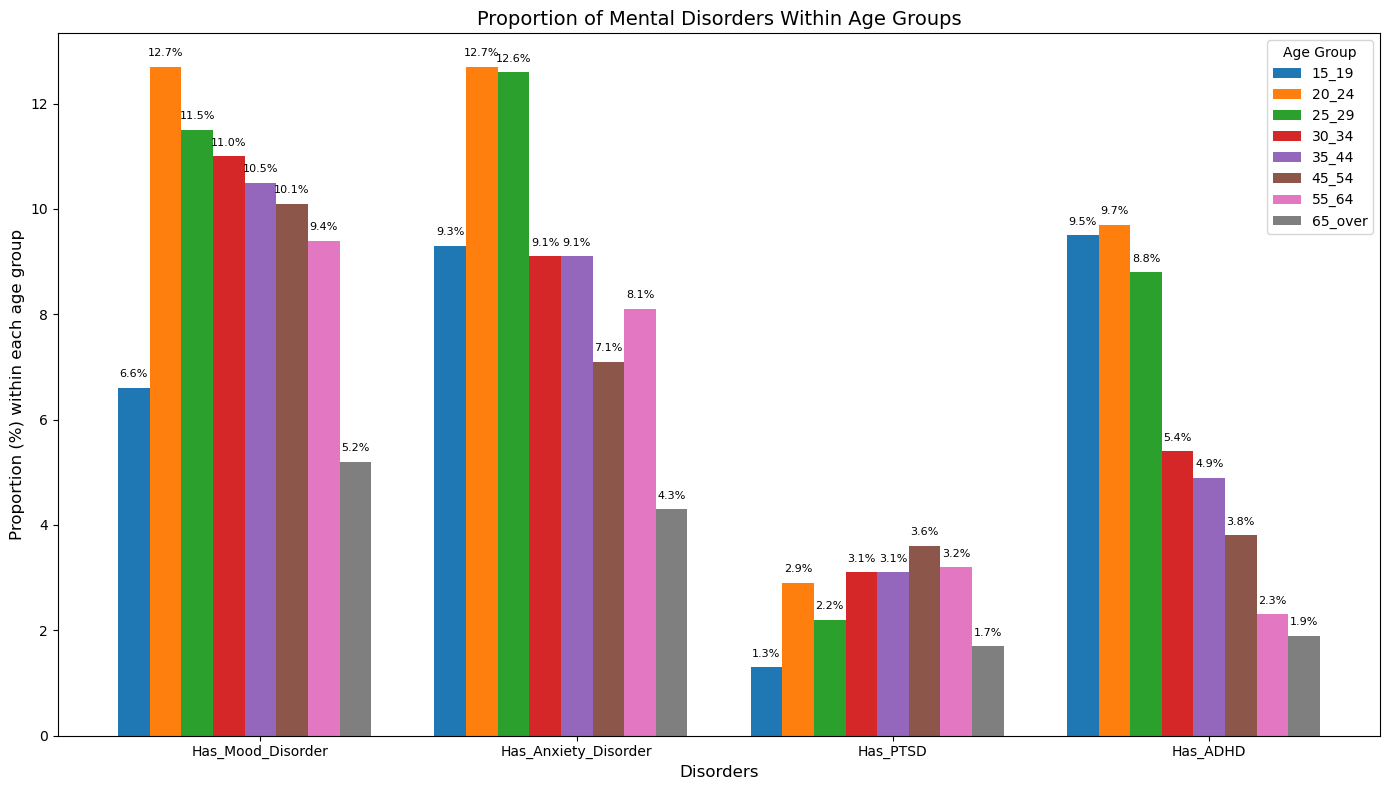

In [35]:
# Define the disorder columns
disorder_columns = [
    'Has_Mood_Disorder',
    'Has_Anxiety_Disorder',
    'Has_PTSD',
    'Has_ADHD'
]

# Define the Age_Group column
age_group_column = 'Age_Group'

# Initialize all age groups (you can adjust these based on your dataset)
age_groups = ['15_19', '20_24', '25_29', '30_34', '35_44', '45_54', '55_64', '65_over']

# Prepare data for proportions
age_group_proportions = {age_group: [] for age_group in age_groups}  # Dictionary to store proportions for each age group

# Initialize the disorder labels list
disorder_labels = []  # List to store disorder names

# Loop through each disorder to calculate proportions within each age group
for disorder in disorder_columns:
    for age_group in age_groups:
        # Filter the data for the specific age group
        group_data = data[data[age_group_column] == age_group]
        
        # Calculate the total count of individuals in this age group
        total_in_group = len(group_data)
        
        # Calculate the proportion of individuals with the disorder in this group
        if total_in_group > 0:  # Avoid division by zero
            count_with_disorder = len(group_data[group_data[disorder] == "Yes"])
            proportion = (count_with_disorder / total_in_group) * 100
        else:
            proportion = 0
        
        # Append the proportion to the respective age group list
        age_group_proportions[age_group].append(round(proportion, 1))
    
    # Add the disorder label
    disorder_labels.append(disorder)

# Function to wrap disorder labels
def wrap_labels(labels, width=20):
    return ['\n'.join(textwrap.wrap(label, width)) for label in labels]

# Wrap disorder labels
wrapped_disorder_labels = wrap_labels(disorder_columns, width=30)

# Create grouped bar chart
x = np.arange(len(disorder_columns))  # x-axis positions for disorders
width = 0.1  # Width of each bar (adjust based on the number of groups)

plt.figure(figsize=(14, 8))

# Plot bars for each age group
for i, age_group in enumerate(age_groups):
    plt.bar(x + (i - len(age_groups) / 2) * width, age_group_proportions[age_group], width, label=age_group)

# Add titles and labels
plt.title('Proportion of Mental Disorders Within Age Groups', fontsize=14)
plt.xlabel('Disorders', fontsize=12)
plt.ylabel('Proportion (%) within each age group', fontsize=12)
plt.xticks(x, wrapped_disorder_labels, rotation=0)  # Apply wrapped labels to x-axis

# Add percentage labels on top of the bars
for i, age_group in enumerate(age_groups):
    for j, proportion in enumerate(age_group_proportions[age_group]):
        if proportion > 0:  # Avoid labeling bars with zero height
            plt.text(x[j] + (i - len(age_groups) / 2) * width, proportion + 0.2, f'{proportion:.1f}%', ha='center', fontsize=8)

# Add legend
plt.legend(title='Age Group')

# Adjust layout and show plot
plt.tight_layout()
plt.show()



# Comparison of Mental Disorders Between Immigrants and Non-Immigrants

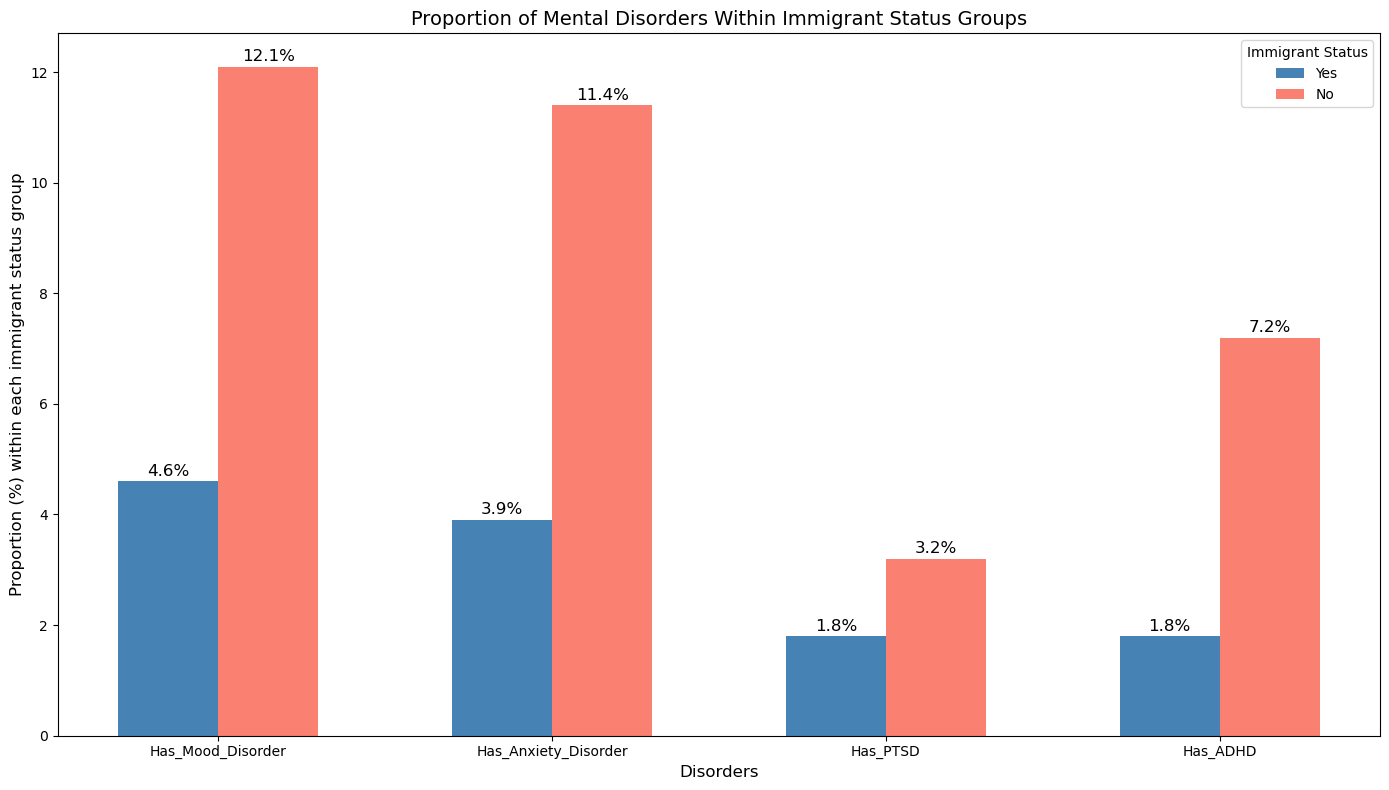

In [38]:
# Define the disorder columns
disorder_columns = [
    'Has_Mood_Disorder',
    'Has_Anxiety_Disorder',
    'Has_PTSD',
    'Has_ADHD'
]

# Define the Is_Immigrant column
immigrant_column = 'Is_Immigrant'

# Prepare data for proportions
immigrant_categories = ['Yes', 'No']  # Immigrant categories
immigrant_proportions = {category: [] for category in immigrant_categories}  # Dictionary to store proportions for each category

# Initialize the disorder labels list
disorder_labels = []  # List to store disorder names

# Loop through each disorder to calculate proportions within each immigrant status group
for disorder in disorder_columns:
    for category in immigrant_categories:
        # Filter the data for the specific immigrant status category
        group_data = data[data[immigrant_column] == category]
        
        # Calculate the total count of individuals in this category
        total_in_group = len(group_data)
        
        # Calculate the proportion of individuals with the disorder in this group
        if total_in_group > 0:  # Avoid division by zero
            count_with_disorder = len(group_data[group_data[disorder] == "Yes"])
            proportion = (count_with_disorder / total_in_group) * 100
        else:
            proportion = 0
        
        # Append the proportion to the respective category list
        immigrant_proportions[category].append(round(proportion, 1))
    
    # Add the disorder label
    disorder_labels.append(disorder)

# Function to wrap disorder labels
def wrap_labels(labels, width=20):
    return ['\n'.join(textwrap.wrap(label, width)) for label in labels]

# Wrap disorder labels
wrapped_disorder_labels = wrap_labels(disorder_columns, width=30)

# Create grouped bar chart
x = np.arange(len(disorder_columns))  # x-axis positions for disorders
width = 0.3  # Width of each bar

plt.figure(figsize=(14, 8))

# Plot bars for Yes and No
bars_yes = plt.bar(x - width/2, immigrant_proportions['Yes'], width, label='Yes', color='steelblue')
bars_no = plt.bar(x + width/2, immigrant_proportions['No'], width, label='No', color='salmon')

# Add titles and labels
plt.title('Proportion of Mental Disorders Within Immigrant Status Groups', fontsize=14)
plt.xlabel('Disorders', fontsize=12)
plt.ylabel('Proportion (%) within each immigrant status group', fontsize=12)
plt.xticks(x, wrapped_disorder_labels, rotation=0)  # Apply wrapped labels to x-axis

# Add percentage labels on top of the bars
for bars, category in zip([bars_yes, bars_no], ['Yes', 'No']):
    for bar in bars:
        height = bar.get_height()
        if height > 0:  # Avoid labeling bars with zero height
            plt.text(bar.get_x() + bar.get_width() / 2, height + 0.1, f'{height:.1f}%', ha='center', fontsize=12)

# Add legend
plt.legend(title='Immigrant Status')

# Adjust layout and show plot
plt.tight_layout()
plt.show()


# Comparison of Mental Health Between Visible and Non-Visible Minority Groups

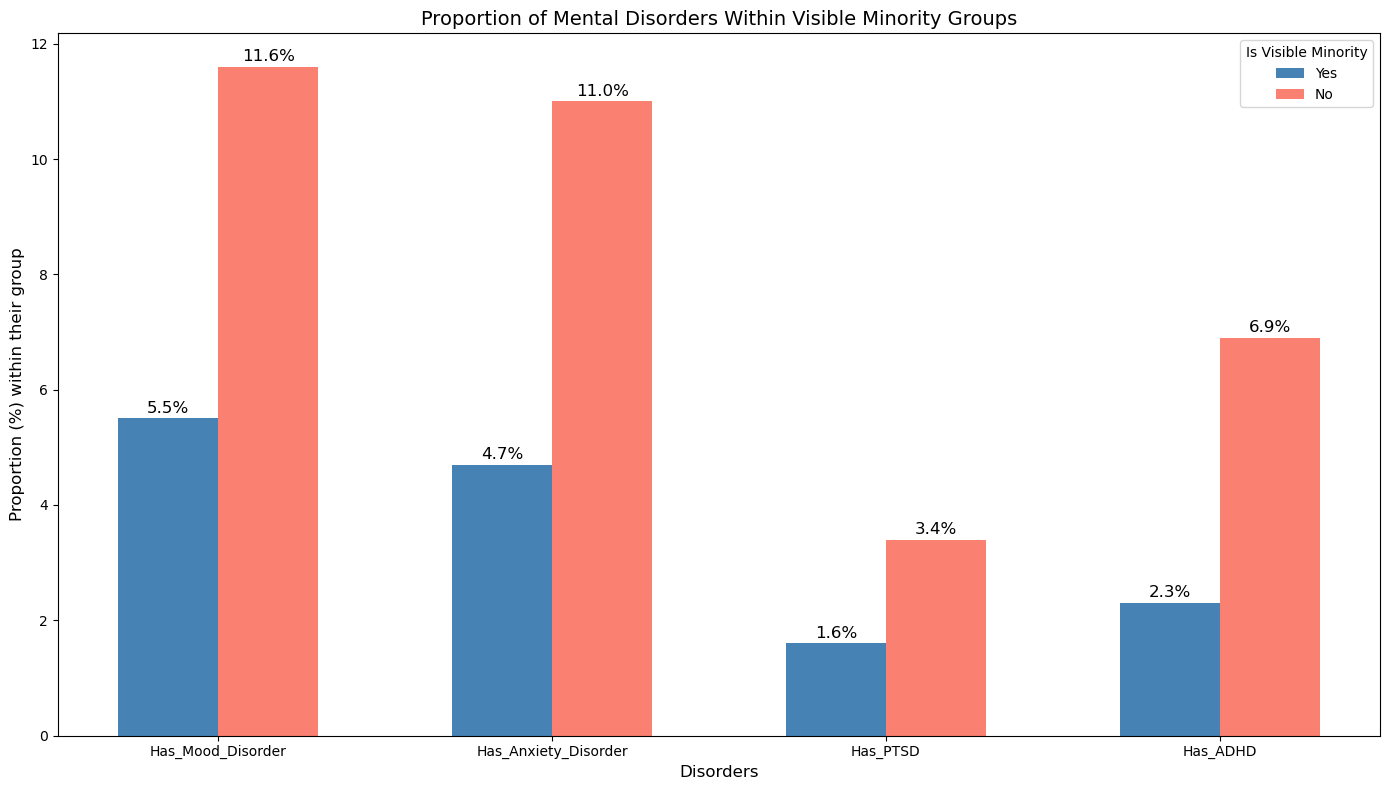

In [41]:
# Define the disorder columns
disorder_columns = [
    'Has_Mood_Disorder',
    'Has_Anxiety_Disorder',
    'Has_PTSD',
    'Has_ADHD'
]

# Define the Is_Visible_Minority column
visible_minority_column = 'Is_Visible_Minority'

# Prepare data for proportions
visible_minority_categories = ['Yes', 'No']  # Visible minority categories
proportions = {category: [] for category in visible_minority_categories}  # Dictionary to store proportions for each category

# Initialize the disorder labels list
disorder_labels = []  # List to store disorder names

# Loop through each disorder to calculate proportions within each visible minority group
for disorder in disorder_columns:
    for category in visible_minority_categories:
        # Filter the data for the specific visible minority category
        group_data = data[data[visible_minority_column] == category]
        
        # Calculate the total count of individuals in this category
        total_in_group = len(group_data)
        
        # Calculate the proportion of individuals with the disorder in this group
        if total_in_group > 0:  # Avoid division by zero
            count_with_disorder = len(group_data[group_data[disorder] == "Yes"])
            proportion = (count_with_disorder / total_in_group) * 100
        else:
            proportion = 0
        
        # Append the proportion to the respective category list
        proportions[category].append(round(proportion, 1))
    
    # Add the disorder label
    disorder_labels.append(disorder)

# Function to wrap disorder labels
def wrap_labels(labels, width=20):
    return ['\n'.join(textwrap.wrap(label, width)) for label in labels]

# Wrap disorder labels
wrapped_disorder_labels = wrap_labels(disorder_columns, width=30)

# Create grouped bar chart
x = np.arange(len(disorder_columns))  # x-axis positions for disorders
width = 0.3  # Width of each bar

plt.figure(figsize=(14, 8))

# Plot bars for Yes and No
bars_yes = plt.bar(x - width/2, proportions['Yes'], width, label='Yes', color='steelblue')
bars_no = plt.bar(x + width/2, proportions['No'], width, label='No', color='salmon')

# Add titles and labels
plt.title('Proportion of Mental Disorders Within Visible Minority Groups', fontsize=14)
plt.xlabel('Disorders', fontsize=12)
plt.ylabel('Proportion (%) within their group', fontsize=12)
plt.xticks(x, wrapped_disorder_labels, rotation=0)  # Apply wrapped labels to x-axis

# Add percentage labels on top of the bars
for bars, category in zip([bars_yes, bars_no], ['Yes', 'No']):
    for bar in bars:
        height = bar.get_height()
        if height > 0:  # Avoid labeling bars with zero height
            plt.text(bar.get_x() + bar.get_width() / 2, height + 0.1, f'{height:.1f}%', ha='center', fontsize=12)

# Add legend
plt.legend(title='Is Visible Minority')

# Adjust layout and show plot
plt.tight_layout()
plt.show()


# Mental Health Disorder Distribution by Visible Minority Group

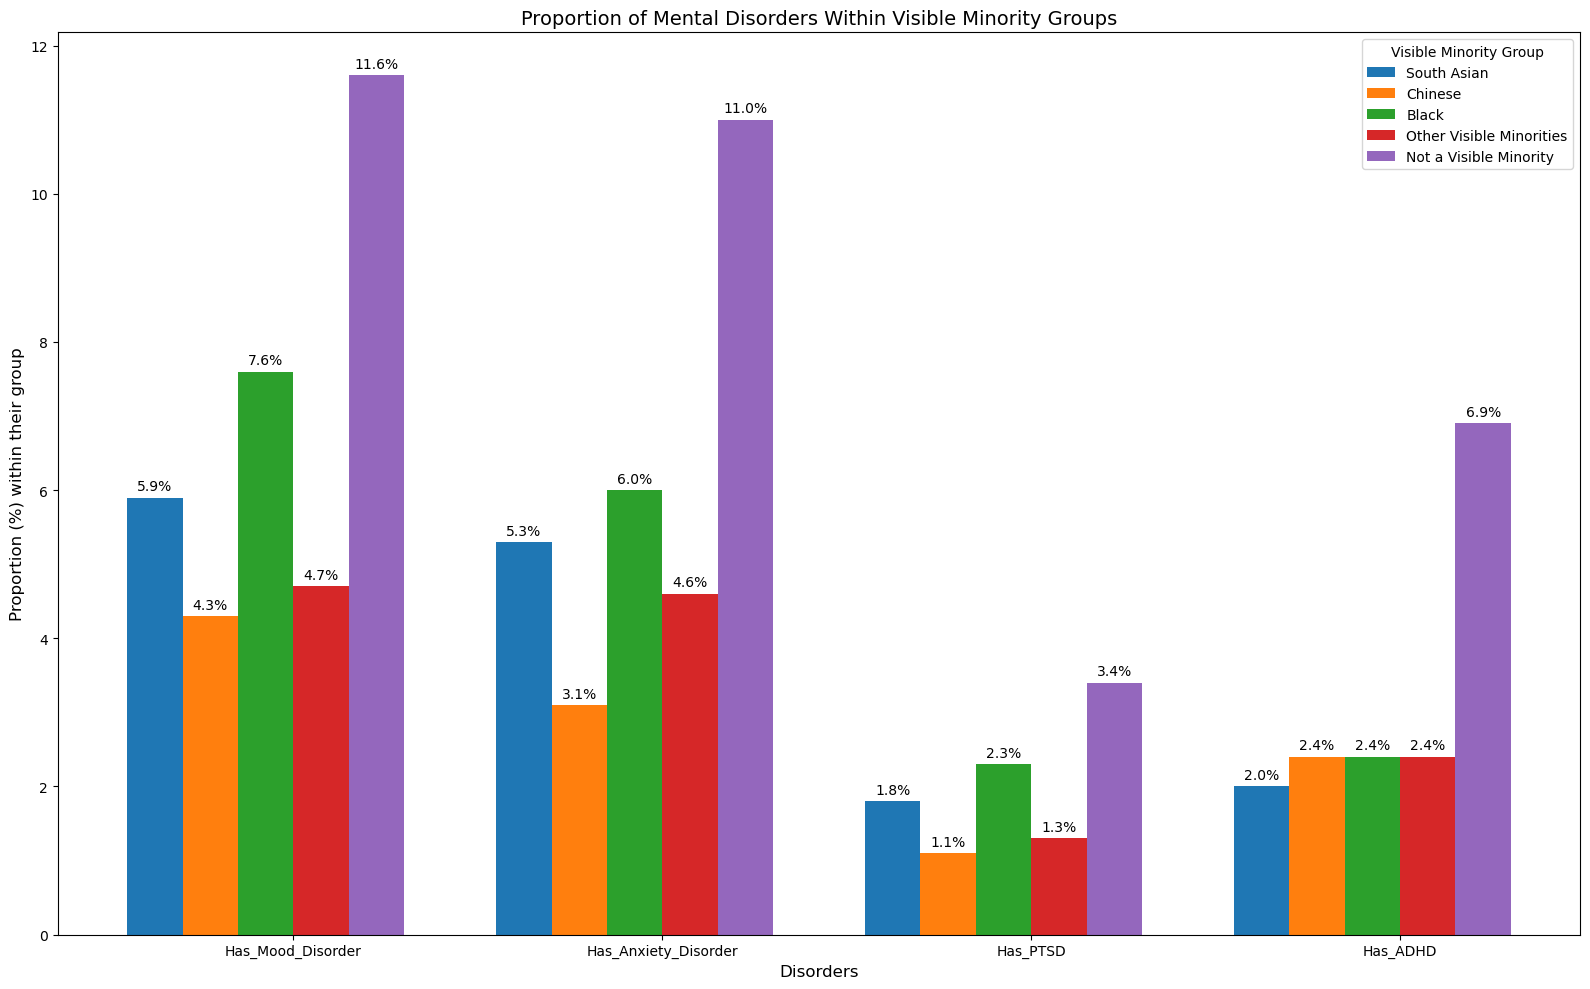

In [44]:
# Define the disorder columns
disorder_columns = [
    'Has_Mood_Disorder',
    'Has_Anxiety_Disorder',
    'Has_PTSD',
    'Has_ADHD'
]

# Define the Visible_Minority_Group column
minority_column = 'Visible_Minority_Group'

# Initialize all visible minority groups (you can adjust these based on your dataset)
minority_groups = ['South Asian', 'Chinese', 'Black', 'Other Visible Minorities', 'Not a Visible Minority']

# Prepare data for proportions
minority_group_proportions = {group: [] for group in minority_groups}  # Dictionary to store proportions for each minority group

# Initialize the disorder labels list
disorder_labels = []  # List to store disorder names

# Loop through each disorder to calculate proportions within each visible minority group
for disorder in disorder_columns:
    for group in minority_groups:
        # Filter the data for the specific visible minority group
        group_data = data[data[minority_column] == group]
        
        # Calculate the total count of individuals in this group
        total_in_group = len(group_data)
        
        # Calculate the proportion of individuals with the disorder in this group
        if total_in_group > 0:  # Avoid division by zero
            count_with_disorder = len(group_data[group_data[disorder] == "Yes"])
            proportion = (count_with_disorder / total_in_group) * 100
        else:
            proportion = 0
        
        # Append the proportion to the respective group list
        minority_group_proportions[group].append(round(proportion, 1))
    
    # Add the disorder label
    disorder_labels.append(disorder)

# Function to wrap disorder labels
def wrap_labels(labels, width=20):
    return ['\n'.join(textwrap.wrap(label, width)) for label in labels]

# Wrap disorder labels
wrapped_disorder_labels = wrap_labels(disorder_columns, width=30)

# Create grouped bar chart
x = np.arange(len(disorder_columns))  # x-axis positions for disorders
width = 0.15  # Width of each bar (adjust based on the number of groups)

plt.figure(figsize=(16, 10))

# Plot bars for each visible minority group
for i, group in enumerate(minority_groups):
    plt.bar(x + (i - len(minority_groups) / 2) * width, minority_group_proportions[group], width, label=group)

# Add titles and labels
plt.title('Proportion of Mental Disorders Within Visible Minority Groups', fontsize=14)
plt.xlabel('Disorders', fontsize=12)
plt.ylabel('Proportion (%) within their group', fontsize=12)
plt.xticks(x, wrapped_disorder_labels, rotation=0)  # Apply wrapped labels to x-axis

# Add percentage labels on top of the bars
for i, group in enumerate(minority_groups):
    for j, proportion in enumerate(minority_group_proportions[group]):
        if proportion > 0:  # Avoid labeling bars with zero height
            plt.text(x[j] + (i - len(minority_groups) / 2) * width, proportion + 0.1, f'{proportion:.1f}%', ha='center', fontsize=10)

# Add legend
plt.legend(title='Visible Minority Group')

# Adjust layout and show plot
plt.tight_layout()
plt.show()



# Mental Disorder Prevalence Across Education Levels

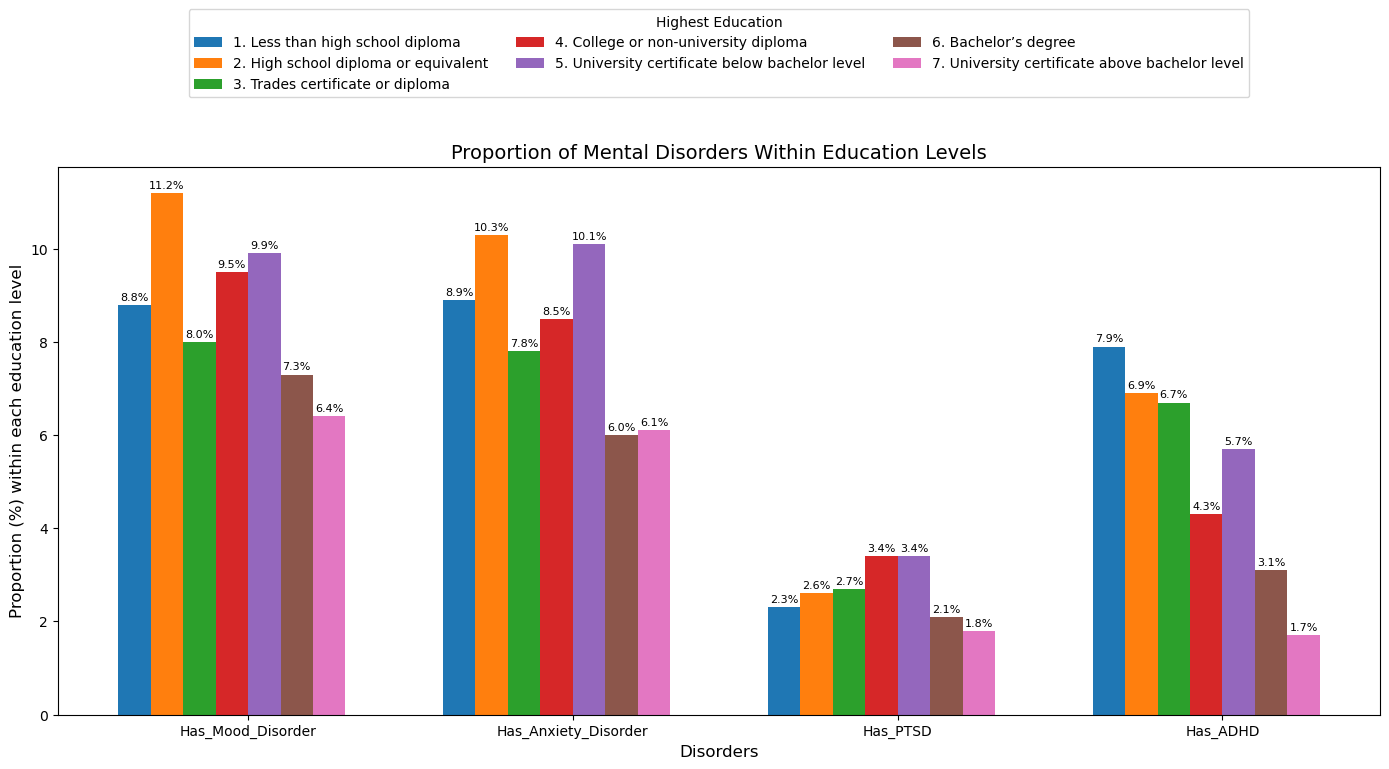

In [47]:
# Define the disorder columns
disorder_columns = [
    'Has_Mood_Disorder',
    'Has_Anxiety_Disorder',
    'Has_PTSD',
    'Has_ADHD'
]

# Define the Highest_Education column
education_column = 'Highest_Education'

# Initialize all education levels (adjust based on your dataset)
education_levels = [
    '1. Less than high school diploma',
    '2. High school diploma or equivalent',
    '3. Trades certificate or diploma',
    '4. College or non-university diploma',
    '5. University certificate below bachelor level',
    '6. Bachelor’s degree',
    '7. University certificate above bachelor level'
]

# Prepare the data for grouped bar chart
disorder_labels = []  # List of disorder names
education_proportions = {level: [] for level in education_levels}  # Dictionary to store proportions for each level

# Initialize the disorder labels list
disorder_labels = []  # List to store disorder names

# Loop through each disorder to calculate proportions within each education level
for disorder in disorder_columns:
    for level in education_levels:
        # Filter the data for the specific education level
        group_data = data[data[education_column] == level]
        
        # Calculate the total count of individuals in this education level
        total_in_group = len(group_data)
        
        # Calculate the proportion of individuals with the disorder in this group
        if total_in_group > 0:  # Avoid division by zero
            count_with_disorder = len(group_data[group_data[disorder] == "Yes"])
            proportion = (count_with_disorder / total_in_group) * 100
        else:
            proportion = 0
        
        # Append the proportion to the respective education level list
        education_proportions[level].append(round(proportion, 1))
    
    # Add the disorder label
    disorder_labels.append(disorder)

# Function to wrap disorder labels
def wrap_labels(labels, width=20):
    return ['\n'.join(textwrap.wrap(label, width)) for label in labels]

# Wrap disorder labels
wrapped_disorder_labels = wrap_labels(disorder_labels, width=30)

# Create grouped bar chart
x = np.arange(len(disorder_labels))  # x-axis positions for disorders
width = 0.1  # Width of each bar (adjust based on the number of groups)

plt.figure(figsize=(14, 8))

# Plot bars for each education level
for i, level in enumerate(education_levels):
    plt.bar(x + (i - len(education_levels) / 2) * width, education_proportions[level], width, label=level)

# Add titles and labels
plt.title('Proportion of Mental Disorders Within Education Levels', fontsize=14)
plt.xlabel('Disorders', fontsize=12)
plt.ylabel('Proportion (%) within each education level', fontsize=12)
plt.xticks(x, wrapped_disorder_labels, rotation=0)  # Apply wrapped labels to x-axis

# Add percentage labels on top of the bars
for i, level in enumerate(education_levels):
    for j, proportion in enumerate(education_proportions[level]):
        if proportion > 0:  # Avoid labeling bars with zero height
            plt.text(x[j] + (i - len(education_levels) / 2) * width, proportion + 0.1, f'{proportion:.1f}%', ha='center', fontsize=8)

# Add legend in the center above the plot
plt.legend(title='Highest Education', loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=3)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


# Data is explored using different dimensions

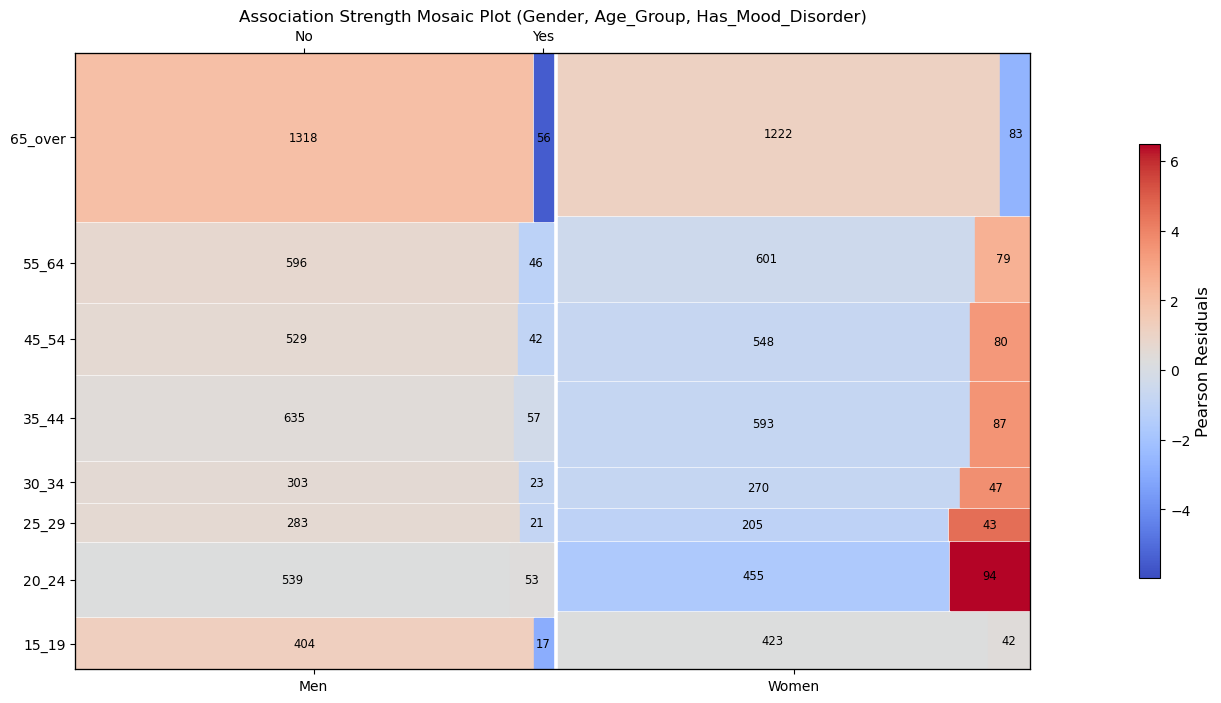

In [17]:
# Define variables
var1 = 'Gender'
var2 = 'Has_Mood_Disorder'
var3 = 'Age_Group'

# Filter and prepare the data
filtered_data = data[[var1, var2, var3]].dropna()

# Create a contingency table
contingency_table = pd.crosstab(
    [filtered_data[var1], filtered_data[var3]],  # Row variables
    filtered_data[var2]  # Column variable
)

# Perform Chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Calculate Pearson residuals
residuals = (contingency_table - expected) / np.sqrt(expected)

# Normalize residuals for color mapping
residuals_norm = residuals / np.abs(residuals).max()

# Prepare the mosaic data
mosaic_data = contingency_table.stack().to_dict()

# Define custom properties for coloring based on residuals
def custom_properties(key):
    # Extract residual for the corresponding cell
    residual = residuals.loc[(key[0], key[1]), key[2]]
    color = mpl.cm.coolwarm((residual + residuals.abs().max().max()) / (2 * residuals.abs().max().max()))
    return {'color': color}

# Custom labelizer for minimal labels
def custom_label(key):
    return f"{mosaic_data[key]}"  # Show only counts

# Create the mosaic plot
fig, ax = plt.subplots(figsize=(14, 8))
mosaic(
    mosaic_data,
    title=f"Association Strength Mosaic Plot ({var1}, {var3}, {var2})",
    labelizer=custom_label,
    properties=custom_properties,
    ax=ax
)

# Add a color bar to indicate residual values
norm = mpl.colors.Normalize(vmin=residuals.min().min(), vmax=residuals.max().max())
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.1)
cbar.set_label("Pearson Residuals", fontsize=12)

plt.show()


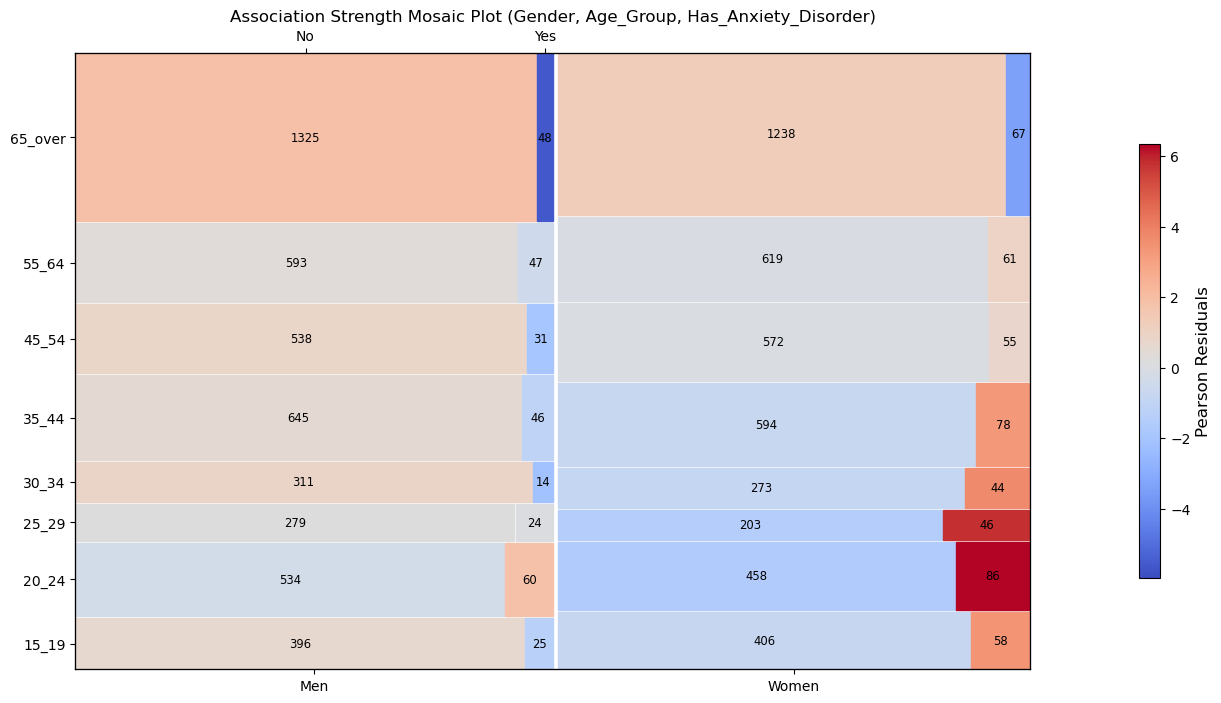

In [19]:
# Define variables
var1 = 'Gender'
var2 = 'Has_Anxiety_Disorder'
var3 = 'Age_Group'

# Filter and prepare the data
filtered_data = data[[var1, var2, var3]].dropna()

# Create a contingency table
contingency_table = pd.crosstab(
    [filtered_data[var1], filtered_data[var3]],  # Row variables
    filtered_data[var2]  # Column variable
)

# Perform Chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Calculate Pearson residuals
residuals = (contingency_table - expected) / np.sqrt(expected)

# Normalize residuals for color mapping
residuals_norm = residuals / np.abs(residuals).max()

# Prepare the mosaic data
mosaic_data = contingency_table.stack().to_dict()

# Define custom properties for coloring based on residuals
def custom_properties(key):
    # Extract residual for the corresponding cell
    residual = residuals.loc[(key[0], key[1]), key[2]]
    color = mpl.cm.coolwarm((residual + residuals.abs().max().max()) / (2 * residuals.abs().max().max()))
    return {'color': color}

# Custom labelizer for minimal labels
def custom_label(key):
    return f"{mosaic_data[key]}"  # Show only counts

# Create the mosaic plot
fig, ax = plt.subplots(figsize=(14, 8))
mosaic(
    mosaic_data,
    title=f"Association Strength Mosaic Plot ({var1}, {var3}, {var2})",
    labelizer=custom_label,
    properties=custom_properties,
    ax=ax
)

# Add a color bar to indicate residual values
norm = mpl.colors.Normalize(vmin=residuals.min().min(), vmax=residuals.max().max())
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.1)
cbar.set_label("Pearson Residuals", fontsize=12)

plt.show()

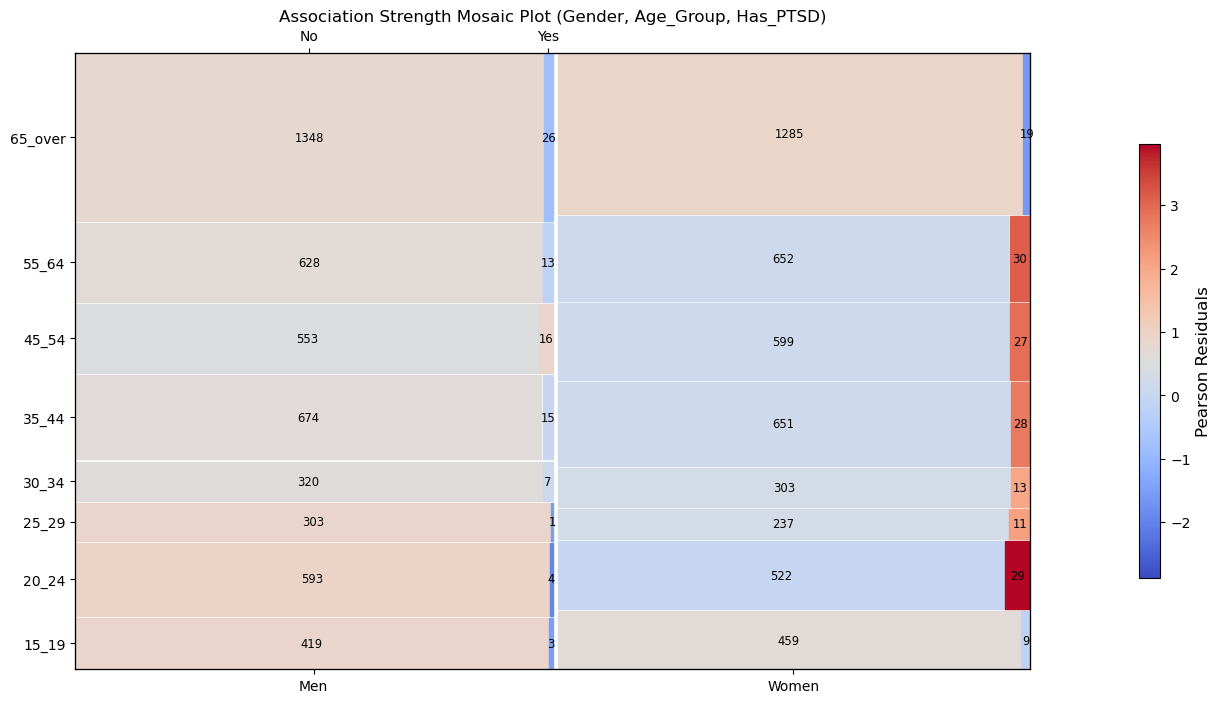

In [21]:
# Define variables
var1 = 'Gender'
var2 = 'Has_PTSD'
var3 = 'Age_Group'

# Filter and prepare the data
filtered_data = data[[var1, var2, var3]].dropna()

# Create a contingency table
contingency_table = pd.crosstab(
    [filtered_data[var1], filtered_data[var3]],  # Row variables
    filtered_data[var2]  # Column variable
)

# Perform Chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Calculate Pearson residuals
residuals = (contingency_table - expected) / np.sqrt(expected)

# Normalize residuals for color mapping
residuals_norm = residuals / np.abs(residuals).max()

# Prepare the mosaic data
mosaic_data = contingency_table.stack().to_dict()

# Define custom properties for coloring based on residuals
def custom_properties(key):
    # Extract residual for the corresponding cell
    residual = residuals.loc[(key[0], key[1]), key[2]]
    color = mpl.cm.coolwarm((residual + residuals.abs().max().max()) / (2 * residuals.abs().max().max()))
    return {'color': color}

# Custom labelizer for minimal labels
def custom_label(key):
    return f"{mosaic_data[key]}"  # Show only counts

# Create the mosaic plot
fig, ax = plt.subplots(figsize=(14, 8))
mosaic(
    mosaic_data,
    title=f"Association Strength Mosaic Plot ({var1}, {var3}, {var2})",
    labelizer=custom_label,
    properties=custom_properties,
    ax=ax
)

# Add a color bar to indicate residual values
norm = mpl.colors.Normalize(vmin=residuals.min().min(), vmax=residuals.max().max())
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.1)
cbar.set_label("Pearson Residuals", fontsize=12)

plt.show()

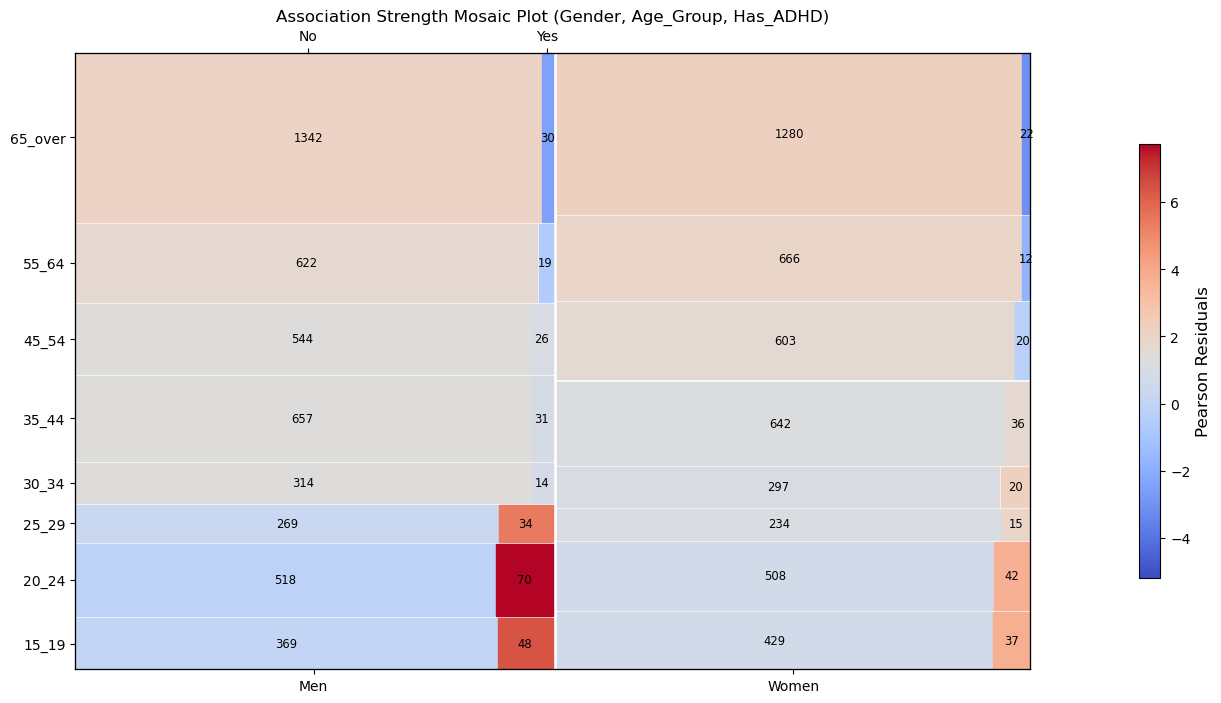

In [23]:
# Define variables
var1 = 'Gender'
var2 = 'Has_ADHD'
var3 = 'Age_Group'

# Filter and prepare the data
filtered_data = data[[var1, var2, var3]].dropna()

# Create a contingency table
contingency_table = pd.crosstab(
    [filtered_data[var1], filtered_data[var3]],  # Row variables
    filtered_data[var2]  # Column variable
)

# Perform Chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Calculate Pearson residuals
residuals = (contingency_table - expected) / np.sqrt(expected)

# Normalize residuals for color mapping
residuals_norm = residuals / np.abs(residuals).max()

# Prepare the mosaic data
mosaic_data = contingency_table.stack().to_dict()

# Define custom properties for coloring based on residuals
def custom_properties(key):
    # Extract residual for the corresponding cell
    residual = residuals.loc[(key[0], key[1]), key[2]]
    color = mpl.cm.coolwarm((residual + residuals.abs().max().max()) / (2 * residuals.abs().max().max()))
    return {'color': color}

# Custom labelizer for minimal labels
def custom_label(key):
    return f"{mosaic_data[key]}"  # Show only counts

# Create the mosaic plot
fig, ax = plt.subplots(figsize=(14, 8))
mosaic(
    mosaic_data,
    title=f"Association Strength Mosaic Plot ({var1}, {var3}, {var2})",
    labelizer=custom_label,
    properties=custom_properties,
    ax=ax
)

# Add a color bar to indicate residual values
norm = mpl.colors.Normalize(vmin=residuals.min().min(), vmax=residuals.max().max())
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.1)
cbar.set_label("Pearson Residuals", fontsize=12)

plt.show()

In [ ]:
'Gender', 'Age_Group', 'Is_Immigrant', 'Visible_Minority_Group', 'Is_Visible_Minority', 'Highest_Education', 'Household_Income', 'LGBTQ2_Status'

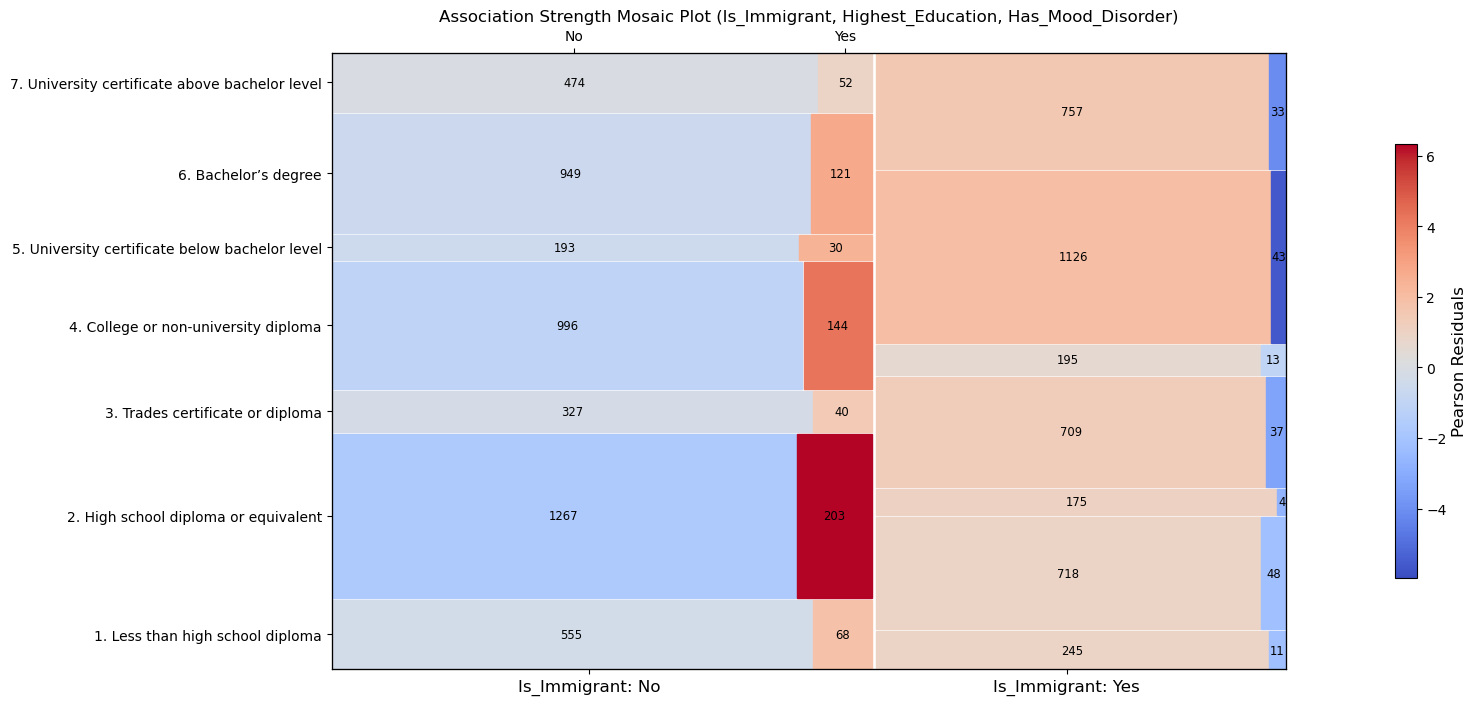

In [51]:
# Define variables
var1 = 'Is_Immigrant'
var2 = 'Has_Mood_Disorder'
var3 = 'Highest_Education'

# Filter and prepare the data
filtered_data = data[[var1, var2, var3]].dropna()

# Create a contingency table
contingency_table = pd.crosstab(
    [filtered_data[var1], filtered_data[var3]],  # Row variables
    filtered_data[var2]  # Column variable
)

# Perform Chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Calculate Pearson residuals
residuals = (contingency_table - expected) / np.sqrt(expected)

# Normalize residuals for color mapping
residuals_norm = residuals / np.abs(residuals).max()

# Prepare the mosaic data
mosaic_data = contingency_table.stack().to_dict()

# Define custom properties for coloring based on residuals
def custom_properties(key):
    # Extract residual for the corresponding cell
    residual = residuals.loc[(key[0], key[1]), key[2]]
    color = mpl.cm.coolwarm((residual + residuals.abs().max().max()) / (2 * residuals.abs().max().max()))
    return {'color': color}

# Custom labelizer for minimal labels
def custom_label(key):
    return f"{mosaic_data[key]}"  # Show only counts

# Create the mosaic plot
fig, ax = plt.subplots(figsize=(14, 8))
mosaic(
    mosaic_data,
    title=f"Association Strength Mosaic Plot ({var1}, {var3}, {var2})",
    labelizer= custom_label,
    properties=custom_properties,
    ax=ax
)

# Set custom x-axis labels
ax.set_xticks([0.27, 0.77])  # Adjust these positions based on the mosaic's layout
ax.set_xticklabels(["Is_Immigrant: No", "Is_Immigrant: Yes"], fontsize=12)

# Add a color bar to indicate residual values
norm = mpl.colors.Normalize(vmin=residuals.min().min(), vmax=residuals.max().max())
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.1)
cbar.set_label("Pearson Residuals", fontsize=12)

plt.show()

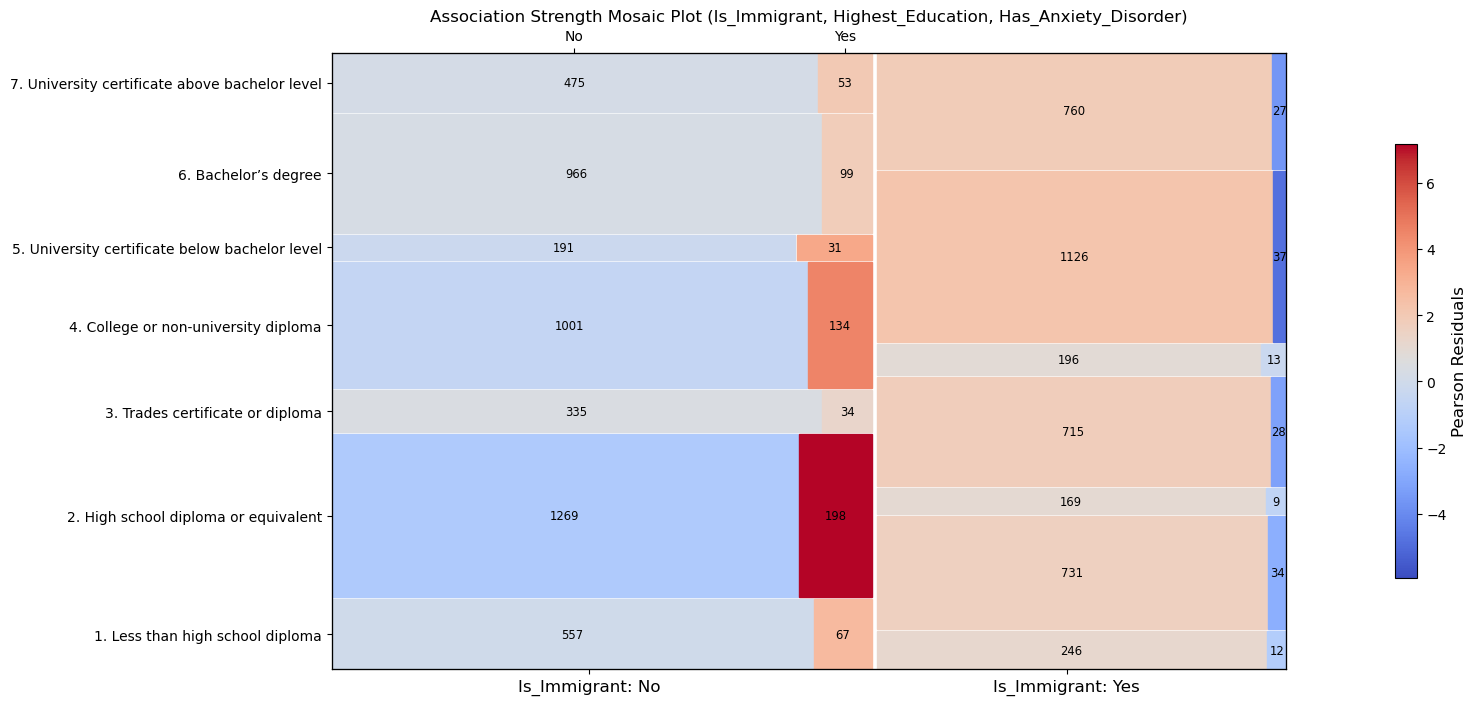

In [53]:
# Define variables
var1 = 'Is_Immigrant'
var2 = 'Has_Anxiety_Disorder'
var3 = 'Highest_Education'

# Filter and prepare the data
filtered_data = data[[var1, var2, var3]].dropna()

# Create a contingency table
contingency_table = pd.crosstab(
    [filtered_data[var1], filtered_data[var3]],  # Row variables
    filtered_data[var2]  # Column variable
)

# Perform Chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Calculate Pearson residuals
residuals = (contingency_table - expected) / np.sqrt(expected)

# Normalize residuals for color mapping
residuals_norm = residuals / np.abs(residuals).max()

# Prepare the mosaic data
mosaic_data = contingency_table.stack().to_dict()

# Define custom properties for coloring based on residuals
def custom_properties(key):
    # Extract residual for the corresponding cell
    residual = residuals.loc[(key[0], key[1]), key[2]]
    color = mpl.cm.coolwarm((residual + residuals.abs().max().max()) / (2 * residuals.abs().max().max()))
    return {'color': color}

# Custom labelizer for minimal labels
def custom_label(key):
    return f"{mosaic_data[key]}"  # Show only counts

# Create the mosaic plot
fig, ax = plt.subplots(figsize=(14, 8))
mosaic(
    mosaic_data,
    title=f"Association Strength Mosaic Plot ({var1}, {var3}, {var2})",
    labelizer= custom_label,
    properties=custom_properties,
    ax=ax
)

# Set custom x-axis labels
ax.set_xticks([0.27, 0.77])  # Adjust these positions based on the mosaic's layout
ax.set_xticklabels(["Is_Immigrant: No", "Is_Immigrant: Yes"], fontsize=12)

# Add a color bar to indicate residual values
norm = mpl.colors.Normalize(vmin=residuals.min().min(), vmax=residuals.max().max())
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.1)
cbar.set_label("Pearson Residuals", fontsize=12)

plt.show()

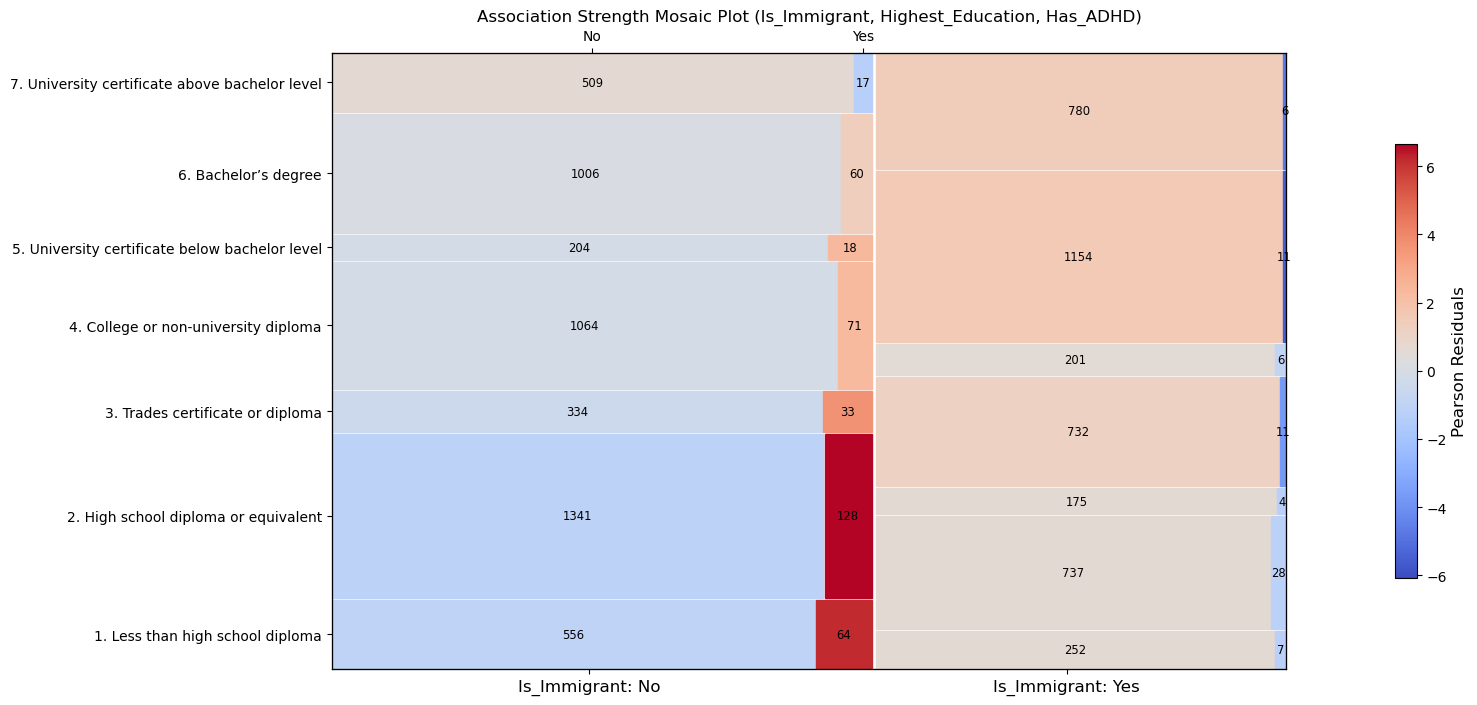

In [67]:
# Define variables
var1 = 'Is_Immigrant'
var2 = 'Has_ADHD'
var3 = 'Highest_Education'

# Filter and prepare the data
filtered_data = data[[var1, var2, var3]].dropna()

# Create a contingency table
contingency_table = pd.crosstab(
    [filtered_data[var1], filtered_data[var3]],  # Row variables
    filtered_data[var2]  # Column variable
)

# Perform Chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Calculate Pearson residuals
residuals = (contingency_table - expected) / np.sqrt(expected)

# Normalize residuals for color mapping
residuals_norm = residuals / np.abs(residuals).max()

# Prepare the mosaic data
mosaic_data = contingency_table.stack().to_dict()

# Define custom properties for coloring based on residuals
def custom_properties(key):
    # Extract residual for the corresponding cell
    residual = residuals.loc[(key[0], key[1]), key[2]]
    color = mpl.cm.coolwarm((residual + residuals.abs().max().max()) / (2 * residuals.abs().max().max()))
    return {'color': color}

# Custom labelizer for minimal labels
def custom_label(key):
    return f"{mosaic_data[key]}"  # Show only counts

# Create the mosaic plot
fig, ax = plt.subplots(figsize=(14, 8))
mosaic(
    mosaic_data,
    title=f"Association Strength Mosaic Plot ({var1}, {var3}, {var2})",
    labelizer= custom_label,
    properties=custom_properties,
    ax=ax
)

# Set custom x-axis labels
ax.set_xticks([0.27, 0.77])  # Adjust these positions based on the mosaic's layout
ax.set_xticklabels(["Is_Immigrant: No", "Is_Immigrant: Yes"], fontsize=12)

# Add a color bar to indicate residual values
norm = mpl.colors.Normalize(vmin=residuals.min().min(), vmax=residuals.max().max())
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.1)
cbar.set_label("Pearson Residuals", fontsize=12)

plt.show()